In [ ]:
!pip install wfdb --no-deps -q


import numpy as np, sys
print("NumPy:", np.__version__)
print("Python:", sys.version)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.6 MB/s eta 0:00:00
NumPy: 2.0.2
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
!pip install -q tensorflow



In [ ]:
import os, random
import numpy as np
import tensorflow as tf
import wfdb
from wfdb import processing

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# MIT-BIH records per class (as in paper, Table 1)
RECORDS = {
    "NOR": [100, 105, 215],
    "LBB": [109, 111, 214],
    "RBB": [118, 124, 212],
    "PVC": [106, 233],
    "APC": [207, 209, 232]
}

# Target sample counts
TARGET_TRAIN = {"NOR":450, "LBB":450, "RBB":450, "APC":450, "PVC":300}
TARGET_TEST  = {"NOR": 90, "LBB": 90, "RBB": 90, "APC": 90, "PVC": 60}

# Sampling details
FS = 360           # Hz
WIN_SEC = 10       # 10-second windows
WIN_SAMPLES = FS * WIN_SEC

# Class mapping
class_to_idx = {"NOR":0, "LBB":1, "RBB":2, "PVC":3, "APC":4}
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Config ready.")


Config ready.


In [ ]:
def read_signal(record_num, fs_target=FS):
    """Read one MIT-BIH record and resample to fs_target."""
    rec = wfdb.rdrecord(str(record_num), pn_dir="mitdb")
    names = [n.lower() for n in rec.sig_name]
    if "v5" in names:
        ch = names.index("v5")
    elif "mlii" in names:
        ch = names.index("mlii")
    else:
        ch = 0
    sig = rec.p_signal[:, ch].astype(np.float32)
    fs = int(rec.fs)
    if fs != fs_target:
        sig = processing.resample_sig(sig, fs, fs_target)[0]
        fs = fs_target
    return sig, fs

def extract_segments(record_num, label, win_samples=WIN_SAMPLES):
    """Extract 10s windows centered on annotated beats of a given label."""
    sig, fs = read_signal(record_num)
    ann = wfdb.rdann(str(record_num), "atr", pn_dir="mitdb")

    out = []
    for idx, sym in zip(ann.sample, ann.symbol):
        # Symbol filtering: map MIT-BIH symbols to classes
        if label == "NOR" and sym == "N":
            center = idx
        elif label == "LBB" and sym == "L":
            center = idx
        elif label == "RBB" and sym == "R":
            center = idx
        elif label == "PVC" and sym == "V":
            center = idx
        elif label == "APC" and sym in ["A", "a"]:  # APC / atrial premature
            center = idx
        else:
            continue

        # Extract 10-second window around beat
        start = max(center - win_samples//2, 0)
        end = start + win_samples
        if end <= len(sig):
            out.append(sig[start:end])
    return out

# Build pools per class
pool = {cls: [] for cls in RECORDS}
for cls, recs in RECORDS.items():
    for r in recs:
        pool[cls].extend(extract_segments(r, cls))
    print(cls, "segments extracted:", len(pool[cls]))


NOR segments extracted: 7936
LBB segments extracted: 6600
RBB segments extracted: 5513
PVC segments extracted: 1347
APC segments extracted: 1860


In [ ]:
rng = np.random.default_rng(SEED)

def take_n(lst, n):
    idx = rng.choice(len(lst), size=min(n, len(lst)), replace=False)
    return [lst[i] for i in idx]

train_X_1d, train_y = [], []
test_X_1d,  test_y  = [], []

for cls in ["NOR","LBB","RBB","APC","PVC"]:
    tr_n, te_n = TARGET_TRAIN[cls], TARGET_TEST[cls]
    cls_pool = pool[cls]

    # Select train
    train_segs = take_n(cls_pool, tr_n)
    chosen = set(id(x) for x in train_segs)

    # Remaining for test
    remaining = [x for x in cls_pool if id(x) not in chosen]
    test_segs = take_n(remaining, te_n)

    train_X_1d += train_segs
    train_y    += [class_to_idx[cls]] * len(train_segs)
    test_X_1d  += test_segs
    test_y     += [class_to_idx[cls]] * len(test_segs)

# Convert to arrays
train_X_1d = np.stack(train_X_1d)  # [N, 3600]
test_X_1d  = np.stack(test_X_1d)
train_y    = np.array(train_y, dtype=np.int64)
test_y     = np.array(test_y, dtype=np.int64)

print("Train:", train_X_1d.shape, {k:int((train_y==v).sum()) for k,v in class_to_idx.items()})
print("Test :", test_X_1d.shape,  {k:int((test_y==v).sum()) for k,v in class_to_idx.items()})


Train: (2100, 3600) {'NOR': 450, 'LBB': 450, 'RBB': 450, 'PVC': 300, 'APC': 450}
Test : (420, 3600) {'NOR': 90, 'LBB': 90, 'RBB': 90, 'PVC': 60, 'APC': 90}


In [ ]:
# === Dataset counts table (standalone cell) ===
# Expects: train_y, test_y, class_to_idx already defined somewhere above.

import numpy as np

# Try pandas for a tidy table; fall back to plain text if not available
try:
    import pandas as pd
    from IPython.display import display
except Exception:
    pd = None
    display = print

def to_int_labels(y):
    y = np.asarray(y)
    return y.argmax(axis=1) if y.ndim == 2 else y.astype(int)

labels = ["NOR","LBB","RBB","APC","PVC"]
ytr = to_int_labels(train_y)
yte = to_int_labels(test_y)

train_counts = {c: int(np.sum(ytr == class_to_idx[c])) for c in labels}
test_counts  = {c: int(np.sum(yte == class_to_idx[c])) for c in labels}
total_counts = {c: train_counts[c] + test_counts[c] for c in labels}

if pd is not None:
    df = pd.DataFrame({
        "Train": [train_counts[c] for c in labels],
        "Test":  [test_counts[c]  for c in labels],
        "Total": [total_counts[c] for c in labels],
    }, index=labels)
    # Grand totals row
    df.loc["Grand total"] = df.sum(numeric_only=True)
    display(df.astype("int64"))
else:
    print(f"{'Class':>6} | {'Train':>5} | {'Test':>5} | {'Total':>5}")
    print("-"*32)
    for c in labels:
        print(f"{c:>6} | {train_counts[c]:5d} | {test_counts[c]:5d} | {total_counts[c]:5d}")
    print("-"*32)
    print(f"{'TOTAL':>6} | {sum(train_counts.values()):5d} | {sum(test_counts.values()):5d} | {sum(total_counts.values()):5d}")

# Optional: quick check against the paper's fixed counts if TARGET_* are defined
try:
    ok = all(train_counts[c]==TARGET_TRAIN[c] and test_counts[c]==TARGET_TEST[c] for c in labels)
    print("Matches paper counts (2100 train, 420 test)" if ok else "Counts differ from paper setup.")
except NameError:
    pass


,Train,Test,Total
NOR,450,90,540
LBB,450,90,540
RBB,450,90,540
APC,450,90,540
PVC,300,60,360
Grand total,2100,420,2520


Matches paper counts (2100 train, 420 test)


In [ ]:
import numpy as np
from PIL import Image
from scipy import signal
from tensorflow.keras.utils import to_categorical

STFT_NPERSEG  = 512   # paper
STFT_NOVERLAP = 256   # reasonable 50% overlap (paper doesn’t state; this is standard)
SPEC_SIZE      = 256   # paper: 256x256 image

def stft_to_image(seg, fs=FS):
    # Symmetric Hann per paper formula (M-1 in the denominator)
    hann_sym = signal.windows.hann(STFT_NPERSEG, sym=True)

    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann_sym,           # exact Hanning window
        nperseg=STFT_NPERSEG,      # 512
        noverlap=STFT_NOVERLAP,    # 50% overlap (paper doesn’t specify; 256 is standard)
        nfft=STFT_NPERSEG,         # 512-point FFT
        boundary=None,             # no zero-padding at the ends
        padded=False               # avoid internal padding
    )

    # magnitude → dB → [0,255] grayscale
    S = np.abs(Z) + 1e-12
    S_db = 20 * np.log10(S / S.max())
    S01 = (S_db - S_db.min()) / (S_db.max() - S_db.min())
    img = Image.fromarray((S01 * 255).astype(np.uint8)).resize((SPEC_SIZE, SPEC_SIZE), Image.BICUBIC)
    return np.array(img, np.uint8)

def make_spec_set(X_1d, y):
    imgs = [stft_to_image(seg, FS) for seg in X_1d]
    X = np.expand_dims(np.array(imgs, np.float32) / 255.0, axis=-1)
    Y = to_categorical(y, num_classes=5)
    return X, Y

train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)
print("Train 2D:", train_X_2d.shape, "Test 2D:", test_X_2d.shape)

Train 2D: (2100, 256, 256, 1) Test 2D: (420, 256, 256, 1)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def make_2d_cnn(input_shape=(SPEC_SIZE, SPEC_SIZE, 1), num_classes=5):
    x = inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (4,4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  # width not fixed in paper; 64 keeps it small and stable
    out = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inp, out, name="ECG_2D_CNN")

model_2d = make_2d_cnn()
model_2d.summary()


Model: "ECG_2D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 13)   │           429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 13)     │           689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       852,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,611 (3.26 MB)

 Trainable params: 853,611 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import keras

LR = 0.001
BATCH = 500
EPOCHS = 100

model_2d.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

hist_2d = model_2d.fit(
    train_X_2d, train_y_oh,
    validation_data=(test_X_2d, test_y_oh),
    epochs=EPOCHS, batch_size=BATCH, verbose=1
)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8630 - loss: 0.6687 - val_accuracy: 0.8310 - val_loss: 0.6357
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9102 - loss: 0.2533 - val_accuracy: 0.8952 - val_loss: 0.3231
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9320 - loss: 0.1881 - val_accuracy: 0.9214 - val_loss: 0.2301
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.9542 - loss: 0.1227 - val_accuracy: 0.9643 - val_loss: 0.1229
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.9846 - loss: 0.0659 - val_accuracy: 0.9690 - val_loss: 0.1368
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9806 - loss: 0.0729 - val_accuracy: 0.9714 - val_loss: 0.1108
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.9884 - loss: 0.0500 - val_accuracy: 0.9643 - val_loss: 0.1138
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.9928 - loss: 0.0388 - val_accuracy: 0.9762 - val

In [ ]:
import numpy as np

tr = np.array(hist_2d.history['accuracy'])
vl = np.array(hist_2d.history.get('val_accuracy', []))

print(f"Final train acc     : {tr[-1]*100:.2f}%")
if vl.size:
    print(f"Final val acc       : {vl[-1]*100:.2f}%")
    print(f"Average train acc   : {tr.mean()*100:.2f}%")
    print(f"Average val acc     : {vl.mean()*100:.2f}%")
    print(f"Best val acc        : {vl.max()*100:.2f}%  (epoch {vl.argmax()+1})")
else:
    print(f"Average train acc   : {tr.mean()*100:.2f}%")


NameError: name 'hist_2d' is not defined

## FULL CODE

In [ ]:
# ============================================================
# ECG Arrhythmia Classification (Paper-faithful full pipeline)
# MIT-BIH: STFT (512 Hann) -> 256x256 spectrogram -> 2D-CNN
# ============================================================

# -------------------------
# 0) Config & dependencies
# -------------------------
import os, random
import numpy as np
import tensorflow as tf
import wfdb
from wfdb import processing

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Records per class (from the paper)
RECORDS = {
    "NOR": [100, 105, 215],
    "LBB": [109, 111, 214],
    "RBB": [118, 124, 212],
    "PVC": [106, 233],
    "APC": [207, 209, 232]
}

# Target split (paper): NOR/LBB/RBB/APC (450 train, 90 test), PVC (300 train, 60 test)
TARGET_TRAIN = {"NOR":450, "LBB":450, "RBB":450, "APC":450, "PVC":300}
TARGET_TEST  = {"NOR": 90, "LBB": 90, "RBB": 90, "APC": 90, "PVC": 60}

# Sampling
FS = 360           # Hz
WIN_SEC = 10       # seconds
WIN_SAMPLES = FS * WIN_SEC

# STFT / Spectrogram (paper/stable choices)
STFT_NPERSEG  = 512   # paper window size
STFT_NOVERLAP = 256   # 50% overlap (paper not explicit; standard)
SPEC_SIZE     = 256   # spectrogram image size (HxW)

# Class mapping
class_to_idx = {"NOR":0, "LBB":1, "RBB":2, "PVC":3, "APC":4}
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Config ready.")

# ------------------------------------------
# 1) Read signals & extract labeled segments
# ------------------------------------------
def read_signal(record_num, fs_target=FS):
    """Read one MIT-BIH record and resample to fs_target."""
    rec = wfdb.rdrecord(str(record_num), pn_dir="mitdb")
    names = [n.lower() for n in rec.sig_name]
    if "v5" in names:
        ch = names.index("v5")
    elif "mlii" in names:
        ch = names.index("mlii")
    else:
        ch = 0
    sig = rec.p_signal[:, ch].astype(np.float32)
    fs = int(rec.fs)
    if fs != fs_target:
        sig = processing.resample_sig(sig, fs, fs_target)[0]
        fs = fs_target
    return sig, fs

def extract_segments(record_num, label, win_samples=WIN_SAMPLES):
    """
    Extract 10s windows centered on annotated beats of a given label.

    Label mapping (MIT-BIH symbols):
      NOR: 'N'
      LBB: 'L'
      RBB: 'R'
      PVC: 'V'
      APC: 'A' or 'a'
    """
    sig, fs = read_signal(record_num)
    ann = wfdb.rdann(str(record_num), "atr", pn_dir="mitdb")

    out = []
    for idx, sym in zip(ann.sample, ann.symbol):
        if   label == "NOR" and sym == "N": center = idx
        elif label == "LBB" and sym == "L": center = idx
        elif label == "RBB" and sym == "R": center = idx
        elif label == "PVC" and sym == "V": center = idx
        elif label == "APC" and sym in ("A","a"): center = idx
        else:
            continue

        # 10s window centered on the beat
        start = max(center - win_samples//2, 0)
        end   = start + win_samples
        if end <= len(sig):
            out.append(sig[start:end])
    return out

# Build pools per class
pool = {cls: [] for cls in RECORDS}
for cls, recs in RECORDS.items():
    for r in recs:
        pool[cls].extend(extract_segments(r, cls))
    print(f"{cls}: segments extracted = {len(pool[cls])}")

# ---------------------------------------
# 2) Paper's fixed train/test split (1D)
# ---------------------------------------
rng = np.random.default_rng(SEED)

def take_n(lst, n):
    idx = rng.choice(len(lst), size=min(n, len(lst)), replace=False)
    return [lst[i] for i in idx]

train_X_1d, train_y = [], []
test_X_1d,  test_y  = [], []

for cls in ["NOR","LBB","RBB","APC","PVC"]:
    tr_n, te_n = TARGET_TRAIN[cls], TARGET_TEST[cls]
    cls_pool = pool[cls]

    train_segs = take_n(cls_pool, tr_n)
    chosen = set(id(x) for x in train_segs)

    remaining = [x for x in cls_pool if id(x) not in chosen]
    test_segs = take_n(remaining, te_n)

    train_X_1d += train_segs
    train_y    += [class_to_idx[cls]] * len(train_segs)
    test_X_1d  += test_segs
    test_y     += [class_to_idx[cls]] * len(test_segs)

# Arrays
train_X_1d = np.stack(train_X_1d)  # [N, 3600]
test_X_1d  = np.stack(test_X_1d)
train_y    = np.array(train_y, dtype=np.int64)
test_y     = np.array(test_y, dtype=np.int64)

print("Train:", train_X_1d.shape, {k:int((train_y==v).sum()) for k,v in class_to_idx.items()})
print("Test :", test_X_1d.shape,  {k:int((test_y==v).sum()) for k,v in class_to_idx.items()})

# Optional: small counts table
try:
    import pandas as pd
    df = pd.DataFrame({
        "Train":[int((train_y==class_to_idx[c]).sum()) for c in class_to_idx],
        "Test":[int((test_y==class_to_idx[c]).sum()) for c in class_to_idx]
    }, index=list(class_to_idx.keys()))
    df["Total"] = df["Train"]+df["Test"]
    display(df)
except Exception:
    pass

# ------------------------------------------
# 3) STFT -> 256x256 grayscale spectrograms
# ------------------------------------------
from PIL import Image
from scipy import signal
from tensorflow.keras.utils import to_categorical

def stft_to_image(seg, fs=FS):
    """
    STFT with symmetric Hann (Hanning) window of 512 (paper),
    50% overlap, magnitude -> dB -> [0,255], resized to 256x256.
    """
    hann_sym = signal.windows.hann(STFT_NPERSEG, sym=True)
    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann_sym,
        nperseg=STFT_NPERSEG,
        noverlap=STFT_NOVERLAP,
        nfft=STFT_NPERSEG,
        boundary=None,
        padded=False
    )
    S = np.abs(Z) + 1e-12
    S_db = 20*np.log10(S / S.max())
    S01 = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-12)
    img = Image.fromarray((S01*255).astype(np.uint8)).resize((SPEC_SIZE, SPEC_SIZE), Image.BICUBIC)
    return np.array(img, np.uint8)

def make_spec_set(X_1d, y):
    imgs = [stft_to_image(seg, FS) for seg in X_1d]
    X = np.expand_dims(np.array(imgs, np.float32)/255.0, axis=-1)  # [N,H,W,1]
    Y = to_categorical(y, num_classes=5)
    return X, Y

train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)
print("Train 2D:", train_X_2d.shape, "Test 2D:", test_X_2d.shape)

# Optional: free 1D arrays to save RAM
import gc
del train_X_1d, test_X_1d
gc.collect()

# (Optional) Save spectrogram tensors so restarts don't hurt
# np.savez_compressed("ecg_spectros.npz",
#     train_X_2d=train_X_2d, train_y_oh=train_y_oh,
#     test_X_2d=test_X_2d,   test_y_oh=test_y_oh
# )

# ---------------------------
# 4) 2D-CNN (paper structure)
# ---------------------------
from tensorflow import keras
from tensorflow.keras import layers

def make_2d_cnn(input_shape=(SPEC_SIZE, SPEC_SIZE, 1), num_classes=5):
    x = inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (4,4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  # dense width not fixed by paper; 64 is a sensible choice
    out = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inp, out, name="ECG_2D_CNN")

model_2d = make_2d_cnn()
model_2d.summary()

# ------------------------------------
# 5) Train (paper LR/epochs; safe Bsz)
# ------------------------------------
LR = 0.001       # paper
EPOCHS = 100     # paper "iterations"
BATCH = 100      # practical; paper used 2500 (too big for most GPUs)

# (Optional) Mixed precision if VRAM is tight (uncomment next 3 lines)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
# train_X_2d, test_X_2d = train_X_2d.astype('float16'), test_X_2d.astype('float16')

# Safety: ensure tensors exist if the runtime was restarted
try:
    _ = train_X_2d.shape; _ = test_X_2d.shape; _ = train_y_oh.shape; _ = test_y_oh.shape
except NameError:
    # Uncomment this if you saved earlier:
    # data = np.load("ecg_spectros.npz")
    # train_X_2d, train_y_oh = data["train_X_2d"], data["train_y_oh"]
    # test_X_2d,  test_y_oh  = data["test_X_2d"],  data["test_y_oh"]
    # Or rebuild:
    train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
    test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)

# Helpful callbacks (optional but recommended)
cbs = [
    #keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

model_2d.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

hist_2d = model_2d.fit(
    train_X_2d, train_y_oh,
    validation_data=(test_X_2d, test_y_oh),
    epochs=EPOCHS, batch_size=BATCH, verbose=1,
    callbacks=cbs
)

# -------------------------
# 6) Report & quick plots
# -------------------------
# Averages / best epoch
tr_acc = np.array(hist_2d.history['accuracy'])
vl_acc = np.array(hist_2d.history['val_accuracy'])
tr_loss = np.array(hist_2d.history['loss'])
vl_loss = np.array(hist_2d.history['val_loss'])

print(f"\nFinal train acc: {tr_acc[-1]*100:.2f}% | Final val acc: {vl_acc[-1]*100:.2f}%")
print(f"Avg  train acc : {tr_acc.mean()*100:.2f}% | Avg  val acc : {vl_acc.mean()*100:.2f}%")
print(f"Best val acc   : {vl_acc.max()*100:.2f}% (epoch {vl_acc.argmax()+1})")
print(f"Final loss     : train {tr_loss[-1]:.4f} | val {vl_loss[-1]:.4f}")

# Optional: exact paper metrics on TEST set
y_prob = model_2d.predict(test_X_2d, verbose=0)
y_pred = y_prob.argmax(axis=1)
y_true = test_y_oh.argmax(axis=1)

acc_pct = (y_pred == y_true).mean()*100.0
eps = 1e-7
ce = -np.sum(test_y_oh * np.log(np.clip(y_prob, eps, 1-eps)), axis=1).mean()

print(f"\n[Paper metrics] Test accuracy: {acc_pct:.2f}% | Cross-entropy: {ce:.6f}")

# Confusion matrix (uses sklearn if available)
try:
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(5)], digits=4))
    # Basic text CM (no seaborn)
    print("Confusion matrix:\n", cm)
except Exception:
    pass


Config ready.
NOR: segments extracted = 7936
LBB: segments extracted = 6600
RBB: segments extracted = 5513
PVC: segments extracted = 1347
APC: segments extracted = 1860
Train: (2100, 3600) {'NOR': 450, 'LBB': 450, 'RBB': 450, 'PVC': 300, 'APC': 450}
Test : (420, 3600) {'NOR': 90, 'LBB': 90, 'RBB': 90, 'PVC': 60, 'APC': 90}


,Train,Test,Total
NOR,450,90,540
LBB,450,90,540
RBB,450,90,540
PVC,300,60,360
APC,450,90,540


Train 2D: (2100, 256, 256, 1) Test 2D: (420, 256, 256, 1)


Model: "ECG_2D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 8)    │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 13)   │           429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 13)     │           689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       852,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,611 (3.26 MB)

 Trainable params: 853,611 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.2017 - loss: 1.6367 - val_accuracy: 0.2143 - val_loss: 1.5947 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.2739 - loss: 1.5865 - val_accuracy: 0.2786 - val_loss: 1.5664 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3497 - loss: 1.5447 - val_accuracy: 0.3714 - val_loss: 1.4855 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.4620 - loss: 1.4104 - val_accuracy: 0.5571 - val_loss: 1.2169 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5746 - loss: 1.1659 - val_accuracy: 0.5714 - val_loss: 1.0646 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6633 - loss: 0.9518 - val_accuracy: 0.7071 - val_loss: 0.8861 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7259 - loss: 0.7989 -

In [ ]:
# ============================================================
# ECG Arrhythmia Classification (Paper-faithful full pipeline)
# MIT-BIH: STFT (512 Hann) -> 256x256 spectrogram -> 2D-CNN
# ============================================================

# -------------------------
# 0) Config & dependencies
# -------------------------
import os, random
import numpy as np
import tensorflow as tf
import wfdb
from wfdb import processing

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Records per class (from the paper)
RECORDS = {
    "NOR": [100, 105, 215],
    "LBB": [109, 111, 214],
    "RBB": [118, 124, 212],
    "PVC": [106, 233],
    "APC": [207, 209, 232]
}

# Target split (paper): NOR/LBB/RBB/APC (450 train, 90 test), PVC (300 train, 60 test)
TARGET_TRAIN = {"NOR":450, "LBB":450, "RBB":450, "APC":450, "PVC":300}
TARGET_TEST  = {"NOR": 90, "LBB": 90, "RBB": 90, "APC": 90, "PVC": 60}

# Sampling
FS = 360           # Hz
WIN_SEC = 10       # seconds
WIN_SAMPLES = FS * WIN_SEC

# STFT / Spectrogram (paper/stable choices)
STFT_NPERSEG  = 512   # paper window size
STFT_NOVERLAP = 256   # 50% overlap (paper not explicit; standard)
SPEC_SIZE     = 256   # spectrogram image size (HxW)

# Class mapping
class_to_idx = {"NOR":0, "LBB":1, "RBB":2, "PVC":3, "APC":4}
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Config ready.")

# ------------------------------------------
# 1) Read signals & extract labeled segments
# ------------------------------------------
def read_signal(record_num, fs_target=FS):
    """Read one MIT-BIH record and resample to fs_target."""
    rec = wfdb.rdrecord(str(record_num), pn_dir="mitdb")
    names = [n.lower() for n in rec.sig_name]
    if "v5" in names:
        ch = names.index("v5")
    elif "mlii" in names:
        ch = names.index("mlii")
    else:
        ch = 0
    sig = rec.p_signal[:, ch].astype(np.float32)
    fs = int(rec.fs)
    if fs != fs_target:
        sig = processing.resample_sig(sig, fs, fs_target)[0]
        fs = fs_target
    return sig, fs

def extract_segments(record_num, label, win_samples=WIN_SAMPLES):
    """
    Extract 10s windows centered on annotated beats of a given label.

    Label mapping (MIT-BIH symbols):
      NOR: 'N'
      LBB: 'L'
      RBB: 'R'
      PVC: 'V'
      APC: 'A' or 'a'
    """
    sig, fs = read_signal(record_num)
    ann = wfdb.rdann(str(record_num), "atr", pn_dir="mitdb")

    out = []
    for idx, sym in zip(ann.sample, ann.symbol):
        if   label == "NOR" and sym == "N": center = idx
        elif label == "LBB" and sym == "L": center = idx
        elif label == "RBB" and sym == "R": center = idx
        elif label == "PVC" and sym == "V": center = idx
        elif label == "APC" and sym in ("A","a"): center = idx
        else:
            continue

        # 10s window centered on the beat
        start = max(center - win_samples//2, 0)
        end   = start + win_samples
        if end <= len(sig):
            out.append(sig[start:end])
    return out

# Build pools per class
pool = {cls: [] for cls in RECORDS}
for cls, recs in RECORDS.items():
    for r in recs:
        pool[cls].extend(extract_segments(r, cls))
    print(f"{cls}: segments extracted = {len(pool[cls])}")

# ---------------------------------------
# 2) Paper's fixed train/test split (1D)
# ---------------------------------------
rng = np.random.default_rng(SEED)

def take_n(lst, n):
    idx = rng.choice(len(lst), size=min(n, len(lst)), replace=False)
    return [lst[i] for i in idx]

train_X_1d, train_y = [], []
test_X_1d,  test_y  = [], []

for cls in ["NOR","LBB","RBB","APC","PVC"]:
    tr_n, te_n = TARGET_TRAIN[cls], TARGET_TEST[cls]
    cls_pool = pool[cls]

    train_segs = take_n(cls_pool, tr_n)
    chosen = set(id(x) for x in train_segs)

    remaining = [x for x in cls_pool if id(x) not in chosen]
    test_segs = take_n(remaining, te_n)

    train_X_1d += train_segs
    train_y    += [class_to_idx[cls]] * len(train_segs)
    test_X_1d  += test_segs
    test_y     += [class_to_idx[cls]] * len(test_segs)

# Arrays
train_X_1d = np.stack(train_X_1d)  # [N, 3600]
test_X_1d  = np.stack(test_X_1d)
train_y    = np.array(train_y, dtype=np.int64)
test_y     = np.array(test_y, dtype=np.int64)

print("Train:", train_X_1d.shape, {k:int((train_y==v).sum()) for k,v in class_to_idx.items()})
print("Test :", test_X_1d.shape,  {k:int((test_y==v).sum()) for k,v in class_to_idx.items()})

# Optional: small counts table
try:
    import pandas as pd
    df = pd.DataFrame({
        "Train":[int((train_y==class_to_idx[c]).sum()) for c in class_to_idx],
        "Test":[int((test_y==class_to_idx[c]).sum()) for c in class_to_idx]
    }, index=list(class_to_idx.keys()))
    df["Total"] = df["Train"]+df["Test"]
    display(df)
except Exception:
    pass

# ------------------------------------------
# 3) STFT -> 256x256 grayscale spectrograms
# ------------------------------------------
from PIL import Image
from scipy import signal
from tensorflow.keras.utils import to_categorical

def stft_to_image(seg, fs=FS):
    """
    STFT with symmetric Hann (Hanning) window of 512 (paper),
    50% overlap, magnitude -> dB -> [0,255], resized to 256x256.
    """
    hann_sym = signal.windows.hann(STFT_NPERSEG, sym=True)
    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann_sym,
        nperseg=STFT_NPERSEG,
        noverlap=STFT_NOVERLAP,
        nfft=STFT_NPERSEG,
        boundary=None,
        padded=False
    )
    S = np.abs(Z) + 1e-12
    S_db = 20*np.log10(S / S.max())
    S01 = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-12)
    img = Image.fromarray((S01*255).astype(np.uint8)).resize((SPEC_SIZE, SPEC_SIZE), Image.BICUBIC)
    return np.array(img, np.uint8)

def make_spec_set(X_1d, y):
    imgs = [stft_to_image(seg, FS) for seg in X_1d]
    X = np.expand_dims(np.array(imgs, np.float32)/255.0, axis=-1)  # [N,H,W,1]
    Y = to_categorical(y, num_classes=5)
    return X, Y

train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)
print("Train 2D:", train_X_2d.shape, "Test 2D:", test_X_2d.shape)

# Optional: free 1D arrays to save RAM
import gc
del train_X_1d, test_X_1d
gc.collect()

# (Optional) Save spectrogram tensors so restarts don't hurt
# np.savez_compressed("ecg_spectros.npz",
#     train_X_2d=train_X_2d, train_y_oh=train_y_oh,
#     test_X_2d=test_X_2d,   test_y_oh=test_y_oh
# )

# ---------------------------
# 4) 2D-CNN (paper structure)
# ---------------------------
from tensorflow import keras
from tensorflow.keras import layers

def make_2d_cnn(input_shape=(SPEC_SIZE, SPEC_SIZE, 1), num_classes=5):
    x = inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (4,4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  # dense width not fixed by paper; 64 is a sensible choice
    out = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inp, out, name="ECG_2D_CNN")

model_2d = make_2d_cnn()
model_2d.summary()

# ------------------------------------
# 5) Train (paper LR/epochs; safe Bsz)
# ------------------------------------
LR = 0.001       # paper
EPOCHS = 100     # paper "iterations"
BATCH = 250    # practical; paper used 2500 (too big for most GPUs)

# (Optional) Mixed precision if VRAM is tight (uncomment next 3 lines)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
# train_X_2d, test_X_2d = train_X_2d.astype('float16'), test_X_2d.astype('float16')

# Safety: ensure tensors exist if the runtime was restarted
try:
    _ = train_X_2d.shape; _ = test_X_2d.shape; _ = train_y_oh.shape; _ = test_y_oh.shape
except NameError:
    # Uncomment this if you saved earlier:
    # data = np.load("ecg_spectros.npz")
    # train_X_2d, train_y_oh = data["train_X_2d"], data["train_y_oh"]
    # test_X_2d,  test_y_oh  = data["test_X_2d"],  data["test_y_oh"]
    # Or rebuild:
    train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
    test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)

# Helpful callbacks (optional but recommended)
cbs = [
    #keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

model_2d.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

hist_2d = model_2d.fit(
    train_X_2d, train_y_oh,
    validation_data=(test_X_2d, test_y_oh),
    epochs=EPOCHS, batch_size=BATCH, verbose=1,
    callbacks=cbs
)

# -------------------------
# 6) Report & quick plots
# -------------------------
# Averages / best epoch
tr_acc = np.array(hist_2d.history['accuracy'])
vl_acc = np.array(hist_2d.history['val_accuracy'])
tr_loss = np.array(hist_2d.history['loss'])
vl_loss = np.array(hist_2d.history['val_loss'])

print(f"\nFinal train acc: {tr_acc[-1]*100:.2f}% | Final val acc: {vl_acc[-1]*100:.2f}%")
print(f"Avg  train acc : {tr_acc.mean()*100:.2f}% | Avg  val acc : {vl_acc.mean()*100:.2f}%")
print(f"Best val acc   : {vl_acc.max()*100:.2f}% (epoch {vl_acc.argmax()+1})")
print(f"Final loss     : train {tr_loss[-1]:.4f} | val {vl_loss[-1]:.4f}")

# Optional: exact paper metrics on TEST set
y_prob = model_2d.predict(test_X_2d, verbose=0)
y_pred = y_prob.argmax(axis=1)
y_true = test_y_oh.argmax(axis=1)

acc_pct = (y_pred == y_true).mean()*100.0
eps = 1e-7
ce = -np.sum(test_y_oh * np.log(np.clip(y_prob, eps, 1-eps)), axis=1).mean()

print(f"\n[Paper metrics] Test accuracy: {acc_pct:.2f}% | Cross-entropy: {ce:.6f}")

# Confusion matrix (uses sklearn if available)
try:
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(5)], digits=4))
    # Basic text CM (no seaborn)
    print("Confusion matrix:\n", cm)
except Exception:
    pass


Config ready.
NOR: segments extracted = 7936
LBB: segments extracted = 6600
RBB: segments extracted = 5513
PVC: segments extracted = 1347
APC: segments extracted = 1860
Train: (2100, 3600) {'NOR': 450, 'LBB': 450, 'RBB': 450, 'PVC': 300, 'APC': 450}
Test : (420, 3600) {'NOR': 90, 'LBB': 90, 'RBB': 90, 'PVC': 60, 'APC': 90}


,Train,Test,Total
NOR,450,90,540
LBB,450,90,540
RBB,450,90,540
PVC,300,60,360
APC,450,90,540


Train 2D: (2100, 256, 256, 1) Test 2D: (420, 256, 256, 1)


Model: "ECG_2D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 8)    │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 13)   │           429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 13)     │           689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       852,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,611 (3.26 MB)

 Trainable params: 853,611 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - accuracy: 0.2107 - loss: 1.6340 - val_accuracy: 0.2190 - val_loss: 1.5951 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.2123 - loss: 1.5925 - val_accuracy: 0.3714 - val_loss: 1.5853 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4351 - loss: 1.5759 - val_accuracy: 0.3476 - val_loss: 1.5610 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4029 - loss: 1.5433 - val_accuracy: 0.4690 - val_loss: 1.5025 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5259 - loss: 1.4641 - val_accuracy: 0.5738 - val_loss: 1.3737 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5939 - loss: 1.3104 - val_accuracy: 0.6429 - val_loss: 1.1945 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.6219 - loss: 1.1218 - val_acc

# adaptive filter

In [ ]:
# ============================================================
# ECG Arrhythmia Classification (Paper-faithful full pipeline)
# MIT-BIH: Adaptive STFT (128/256/512 Hann) -> 256x256x3 spectrogram -> 2D-CNN
# ============================================================

# -------------------------
# 0) Config & dependencies
# -------------------------
import os, random
import numpy as np
import tensorflow as tf
import wfdb
from wfdb import processing

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Records per class (from the paper)
RECORDS = {
    "NOR": [100, 105, 215],
    "LBB": [109, 111, 214],
    "RBB": [118, 124, 212],
    "PVC": [106, 233],
    "APC": [207, 209, 232]
}

# Target split (paper): NOR/LBB/RBB/APC (450 train, 90 test), PVC (300 train, 60 test)
TARGET_TRAIN = {"NOR":450, "LBB":450, "RBB":450, "APC":450, "PVC":300}
TARGET_TEST  = {"NOR": 90, "LBB": 90, "RBB": 90, "APC": 90, "PVC": 60}

# Sampling
FS = 360           # Hz
WIN_SEC = 10       # seconds
WIN_SAMPLES = FS * WIN_SEC

# Adaptive STFT / Spectrogram (multi-window front-end)
# We use 3 window sizes: 128, 256, 512 (Hann), each with 50% overlap
STFT_WINDOW_SIZES = [128, 256, 512]
SPEC_SIZE         = 256   # spectrogram image size (HxW)

# Class mapping
class_to_idx = {"NOR":0, "LBB":1, "RBB":2, "PVC":3, "APC":4}
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Config ready.")

# ------------------------------------------
# 1) Read signals & extract labeled segments
# ------------------------------------------
def read_signal(record_num, fs_target=FS):
    """Read one MIT-BIH record and resample to fs_target."""
    rec = wfdb.rdrecord(str(record_num), pn_dir="mitdb")
    names = [n.lower() for n in rec.sig_name]
    if "v5" in names:
        ch = names.index("v5")
    elif "mlii" in names:
        ch = names.index("mlii")
    else:
        ch = 0
    sig = rec.p_signal[:, ch].astype(np.float32)
    fs = int(rec.fs)
    if fs != fs_target:
        sig = processing.resample_sig(sig, fs, fs_target)[0]
        fs = fs_target
    return sig, fs

def extract_segments(record_num, label, win_samples=WIN_SAMPLES):
    """
    Extract 10s windows centered on annotated beats of a given label.

    Label mapping (MIT-BIH symbols):
      NOR: 'N'
      LBB: 'L'
      RBB: 'R'
      PVC: 'V'
      APC: 'A' or 'a'
    """
    sig, fs = read_signal(record_num)
    ann = wfdb.rdann(str(record_num), "atr", pn_dir="mitdb")

    out = []
    for idx, sym in zip(ann.sample, ann.symbol):
        if   label == "NOR" and sym == "N": center = idx
        elif label == "LBB" and sym == "L": center = idx
        elif label == "RBB" and sym == "R": center = idx
        elif label == "PVC" and sym == "V": center = idx
        elif label == "APC" and sym in ("A","a"): center = idx
        else:
            continue

        # 10s window centered on the beat
        start = max(center - win_samples//2, 0)
        end   = start + win_samples
        if end <= len(sig):
            out.append(sig[start:end])
    return out

# Build pools per class
pool = {cls: [] for cls in RECORDS}
for cls, recs in RECORDS.items():
    for r in recs:
        pool[cls].extend(extract_segments(r, cls))
    print(f"{cls}: segments extracted = {len(pool[cls])}")

# ---------------------------------------
# 2) Paper's fixed train/test split (1D)
# ---------------------------------------
rng = np.random.default_rng(SEED)

def take_n(lst, n):
    idx = rng.choice(len(lst), size=min(n, len(lst)), replace=False)
    return [lst[i] for i in idx]

train_X_1d, train_y = [], []
test_X_1d,  test_y  = [], []

for cls in ["NOR","LBB","RBB","APC","PVC"]:
    tr_n, te_n = TARGET_TRAIN[cls], TARGET_TEST[cls]
    cls_pool = pool[cls]

    train_segs = take_n(cls_pool, tr_n)
    chosen = set(id(x) for x in train_segs)

    remaining = [x for x in cls_pool if id(x) not in chosen]
    test_segs = take_n(remaining, te_n)

    train_X_1d += train_segs
    train_y    += [class_to_idx[cls]] * len(train_segs)
    test_X_1d  += test_segs
    test_y     += [class_to_idx[cls]] * len(test_segs)

# Arrays
train_X_1d = np.stack(train_X_1d)  # [N, 3600]
test_X_1d  = np.stack(test_X_1d)
train_y    = np.array(train_y, dtype=np.int64)
test_y     = np.array(test_y, dtype=np.int64)

print("Train:", train_X_1d.shape, {k:int((train_y==v).sum()) for k,v in class_to_idx.items()})
print("Test :", test_X_1d.shape,  {k:int((test_y==v).sum()) for k,v in class_to_idx.items()})

# Optional: small counts table
try:
    import pandas as pd
    df = pd.DataFrame({
        "Train":[int((train_y==class_to_idx[c]).sum()) for c in class_to_idx],
        "Test":[int((test_y==class_to_idx[c]).sum()) for c in class_to_idx]
    }, index=list(class_to_idx.keys()))
    df["Total"] = df["Train"]+df["Test"]
    display(df)
except Exception:
    pass

# -------------------------------------------------
# 3) Adaptive STFT -> 256x256x3 spectrogram images
# -------------------------------------------------
from PIL import Image
from scipy import signal
from tensorflow.keras.utils import to_categorical

def stft_single_window_to_image(seg, fs, nperseg, noverlap):
    """
    STFT with symmetric Hann window of size nperseg,
    'noverlap' overlap, magnitude -> dB -> [0,255], resized to 256x256.
    Returns a 2D uint8 image.
    """
    hann_sym = signal.windows.hann(nperseg, sym=True)
    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann_sym,
        nperseg=nperseg,
        noverlap=noverlap,
        nfft=nperseg,
        boundary=None,
        padded=False
    )
    S = np.abs(Z) + 1e-12
    S_db = 20*np.log10(S / S.max())
    S01 = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-12)
    img = Image.fromarray((S01*255).astype(np.uint8)).resize((SPEC_SIZE, SPEC_SIZE), Image.BICUBIC)
    return np.array(img, np.uint8)  # [H,W]

def stft_multi_to_image(seg, fs=FS):
    """
    Adaptive front-end:
      - Compute STFT spectrograms with 3 different Hann windows
        (128, 256, 512 samples; each 50% overlap).
      - Convert each to a 256x256 grayscale image.
      - Stack as 3 channels -> 256x256x3.
    """
    chans = []
    for nperseg in STFT_WINDOW_SIZES:
        noverlap = nperseg // 2   # 50% overlap
        img2d = stft_single_window_to_image(seg, fs, nperseg, noverlap)  # [H,W]
        chans.append(img2d)
    img3 = np.stack(chans, axis=-1)  # [H,W,3], uint8
    return img3

def make_spec_set(X_1d, y):
    # Each segment -> 3-channel spectrogram image
    imgs = [stft_multi_to_image(seg, FS) for seg in X_1d]
    X = np.array(imgs, np.float32) / 255.0  # [N,H,W,3]
    Y = to_categorical(y, num_classes=5)
    return X, Y

train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)
print("Train 2D:", train_X_2d.shape, "Test 2D:", test_X_2d.shape)
# Expect: (N, 256, 256, 3)

# Optional: free 1D arrays to save RAM
import gc
del train_X_1d, test_X_1d
gc.collect()

# (Optional) Save spectrogram tensors so restarts don't hurt
# np.savez_compressed("ecg_spectros_multiwin.npz",
#     train_X_2d=train_X_2d, train_y_oh=train_y_oh,
#     test_X_2d=test_X_2d,   test_y_oh=test_y_oh
# )

# ---------------------------
# 4) 2D-CNN (paper structure)
#     Now with 3-channel input
# ---------------------------
from tensorflow import keras
from tensorflow.keras import layers

def make_2d_cnn(input_shape=(SPEC_SIZE, SPEC_SIZE, 3), num_classes=5):
    x = inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (4,4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  # dense width not fixed by paper; 64 is a sensible choice
    out = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inp, out, name="ECG_2D_CNN_MultiWindowSTFT")

model_2d = make_2d_cnn()
model_2d.summary()

# ------------------------------------
# 5) Train (paper LR/epochs; safe Bsz)
# ------------------------------------
LR = 0.001       # paper
EPOCHS = 100     # paper "iterations"
BATCH = 250      # practical; paper used 2500 (too big for most GPUs)

# (Optional) Mixed precision if VRAM is tight (uncomment next 3 lines)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
# train_X_2d, test_X_2d = train_X_2d.astype('float16'), test_X_2d.astype('float16')

# Safety: ensure tensors exist if the runtime was restarted
try:
    _ = train_X_2d.shape; _ = test_X_2d.shape; _ = train_y_oh.shape; _ = test_y_oh.shape
except NameError:
    # Uncomment this if you saved earlier:
    # data = np.load("ecg_spectros_multiwin.npz")
    # train_X_2d, train_y_oh = data["train_X_2d"], data["train_y_oh"]
    # test_X_2d,  test_y_oh  = data["test_X_2d"],  data["test_y_oh"]
    # Or rebuild:
    train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
    test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)

# Helpful callbacks (optional but recommended)
cbs = [
    # keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

model_2d.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

hist_2d = model_2d.fit(
    train_X_2d, train_y_oh,
    validation_data=(test_X_2d, test_y_oh),
    epochs=EPOCHS, batch_size=BATCH, verbose=1,
    callbacks=cbs
)

# -------------------------
# 6) Report & quick plots
# -------------------------
# Averages / best epoch
tr_acc = np.array(hist_2d.history['accuracy'])
vl_acc = np.array(hist_2d.history['val_accuracy'])
tr_loss = np.array(hist_2d.history['loss'])
vl_loss = np.array(hist_2d.history['val_loss'])

print(f"\nFinal train acc: {tr_acc[-1]*100:.2f}% | Final val acc: {vl_acc[-1]*100:.2f}%")
print(f"Avg  train acc : {tr_acc.mean()*100:.2f}% | Avg  val acc : {vl_acc.mean()*100:.2f}%")
print(f"Best val acc   : {vl_acc.max()*100:.2f}% (epoch {vl_acc.argmax()+1})")
print(f"Final loss     : train {tr_loss[-1]:.4f} | val {vl_loss[-1]:.4f}")

# Optional: exact paper metrics on TEST set
y_prob = model_2d.predict(test_X_2d, verbose=0)
y_pred = y_prob.argmax(axis=1)
y_true = test_y_oh.argmax(axis=1)

acc_pct = (y_pred == y_true).mean()*100.0
eps = 1e-7
ce = -np.sum(test_y_oh * np.log(np.clip(y_prob, eps, 1-eps)), axis=1).mean()

print(f"\n[Paper metrics] Test accuracy: {acc_pct:.2f}% | Cross-entropy: {ce:.6f}")

# Confusion matrix (uses sklearn if available)
try:
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(5)], digits=4))
    # Basic text CM (no seaborn)
    print("Confusion matrix:\n", cm)
except Exception:
    pass


Config ready.
NOR: segments extracted = 7936
LBB: segments extracted = 6600
RBB: segments extracted = 5513
PVC: segments extracted = 1347
APC: segments extracted = 1860
Train: (2100, 3600) {'NOR': 450, 'LBB': 450, 'RBB': 450, 'PVC': 300, 'APC': 450}
Test : (420, 3600) {'NOR': 90, 'LBB': 90, 'RBB': 90, 'PVC': 60, 'APC': 90}


,Train,Test,Total
NOR,450,90,540
LBB,450,90,540
RBB,450,90,540
PVC,300,60,360
APC,450,90,540


Train 2D: (2100, 256, 256, 3) Test 2D: (420, 256, 256, 3)


Model: "ECG_2D_CNN_MultiWindowSTFT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 8)    │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 13)   │           429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 13)     │           689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       852,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,867 (3.26 MB)

 Trainable params: 853,867 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 561ms/step - accuracy: 0.2258 - loss: 1.6137 - val_accuracy: 0.4476 - val_loss: 1.5612 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.4495 - loss: 1.5302 - val_accuracy: 0.5762 - val_loss: 1.4422 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.6351 - loss: 1.3699 - val_accuracy: 0.6381 - val_loss: 1.1956 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.7536 - loss: 1.0837 - val_accuracy: 0.8190 - val_loss: 0.8147 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.8615 - loss: 0.7244 - val_accuracy: 0.8405 - val_loss: 0.5410 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.8803 - loss: 0.4735 - val_accuracy: 0.9048 - val_loss: 0.3847 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.9150 - loss: 0.3155 - val_acc

# 500 batch size

In [ ]:
# ============================================================
# ECG Arrhythmia Classification (Paper-faithful full pipeline)
# MIT-BIH: STFT (512 Hann) -> 256x256 spectrogram -> 2D-CNN
# ============================================================

# -------------------------
# 0) Config & dependencies
# -------------------------
import os, random
import numpy as np
import tensorflow as tf
import wfdb
from wfdb import processing

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Records per class (from the paper)
RECORDS = {
    "NOR": [100, 105, 215],
    "LBB": [109, 111, 214],
    "RBB": [118, 124, 212],
    "PVC": [106, 233],
    "APC": [207, 209, 232]
}

# Target split (paper): NOR/LBB/RBB/APC (450 train, 90 test), PVC (300 train, 60 test)
TARGET_TRAIN = {"NOR":450, "LBB":450, "RBB":450, "APC":450, "PVC":300}
TARGET_TEST  = {"NOR": 90, "LBB": 90, "RBB": 90, "APC": 90, "PVC": 60}

# Sampling
FS = 360           # Hz
WIN_SEC = 10       # seconds
WIN_SAMPLES = FS * WIN_SEC

# STFT / Spectrogram (paper/stable choices)
STFT_NPERSEG  = 512   # paper window size
STFT_NOVERLAP = 256   # 50% overlap (paper not explicit; standard)
SPEC_SIZE     = 256   # spectrogram image size (HxW)

# Class mapping
class_to_idx = {"NOR":0, "LBB":1, "RBB":2, "PVC":3, "APC":4}
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Config ready.")

# ------------------------------------------
# 1) Read signals & extract labeled segments
# ------------------------------------------
def read_signal(record_num, fs_target=FS):
    """Read one MIT-BIH record and resample to fs_target."""
    rec = wfdb.rdrecord(str(record_num), pn_dir="mitdb")
    names = [n.lower() for n in rec.sig_name]
    if "v5" in names:
        ch = names.index("v5")
    elif "mlii" in names:
        ch = names.index("mlii")
    else:
        ch = 0
    sig = rec.p_signal[:, ch].astype(np.float32)
    fs = int(rec.fs)
    if fs != fs_target:
        sig = processing.resample_sig(sig, fs, fs_target)[0]
        fs = fs_target
    return sig, fs

def extract_segments(record_num, label, win_samples=WIN_SAMPLES):
    """
    Extract 10s windows centered on annotated beats of a given label.

    Label mapping (MIT-BIH symbols):
      NOR: 'N'
      LBB: 'L'
      RBB: 'R'
      PVC: 'V'
      APC: 'A' or 'a'
    """
    sig, fs = read_signal(record_num)
    ann = wfdb.rdann(str(record_num), "atr", pn_dir="mitdb")

    out = []
    for idx, sym in zip(ann.sample, ann.symbol):
        if   label == "NOR" and sym == "N": center = idx
        elif label == "LBB" and sym == "L": center = idx
        elif label == "RBB" and sym == "R": center = idx
        elif label == "PVC" and sym == "V": center = idx
        elif label == "APC" and sym in ("A","a"): center = idx
        else:
            continue

        # 10s window centered on the beat
        start = max(center - win_samples//2, 0)
        end   = start + win_samples
        if end <= len(sig):
            out.append(sig[start:end])
    return out

# Build pools per class
pool = {cls: [] for cls in RECORDS}
for cls, recs in RECORDS.items():
    for r in recs:
        pool[cls].extend(extract_segments(r, cls))
    print(f"{cls}: segments extracted = {len(pool[cls])}")

# ---------------------------------------
# 2) Paper's fixed train/test split (1D)
# ---------------------------------------
rng = np.random.default_rng(SEED)

def take_n(lst, n):
    idx = rng.choice(len(lst), size=min(n, len(lst)), replace=False)
    return [lst[i] for i in idx]

train_X_1d, train_y = [], []
test_X_1d,  test_y  = [], []

for cls in ["NOR","LBB","RBB","APC","PVC"]:
    tr_n, te_n = TARGET_TRAIN[cls], TARGET_TEST[cls]
    cls_pool = pool[cls]

    train_segs = take_n(cls_pool, tr_n)
    chosen = set(id(x) for x in train_segs)

    remaining = [x for x in cls_pool if id(x) not in chosen]
    test_segs = take_n(remaining, te_n)

    train_X_1d += train_segs
    train_y    += [class_to_idx[cls]] * len(train_segs)
    test_X_1d  += test_segs
    test_y     += [class_to_idx[cls]] * len(test_segs)

# Arrays
train_X_1d = np.stack(train_X_1d)  # [N, 3600]
test_X_1d  = np.stack(test_X_1d)
train_y    = np.array(train_y, dtype=np.int64)
test_y     = np.array(test_y, dtype=np.int64)

print("Train:", train_X_1d.shape, {k:int((train_y==v).sum()) for k,v in class_to_idx.items()})
print("Test :", test_X_1d.shape,  {k:int((test_y==v).sum()) for k,v in class_to_idx.items()})

# Optional: small counts table
try:
    import pandas as pd
    df = pd.DataFrame({
        "Train":[int((train_y==class_to_idx[c]).sum()) for c in class_to_idx],
        "Test":[int((test_y==class_to_idx[c]).sum()) for c in class_to_idx]
    }, index=list(class_to_idx.keys()))
    df["Total"] = df["Train"]+df["Test"]
    display(df)
except Exception:
    pass

# ------------------------------------------
# 3) STFT -> 256x256 grayscale spectrograms
# ------------------------------------------
from PIL import Image
from scipy import signal
from tensorflow.keras.utils import to_categorical

def stft_to_image(seg, fs=FS):
    """
    STFT with symmetric Hann (Hanning) window of 512 (paper),
    50% overlap, magnitude -> dB -> [0,255], resized to 256x256.
    """
    hann_sym = signal.windows.hann(STFT_NPERSEG, sym=True)
    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann_sym,
        nperseg=STFT_NPERSEG,
        noverlap=STFT_NOVERLAP,
        nfft=STFT_NPERSEG,
        boundary=None,
        padded=False
    )
    S = np.abs(Z) + 1e-12
    S_db = 20*np.log10(S / S.max())
    S01 = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-12)
    img = Image.fromarray((S01*255).astype(np.uint8)).resize((SPEC_SIZE, SPEC_SIZE), Image.BICUBIC)
    return np.array(img, np.uint8)

def make_spec_set(X_1d, y):
    imgs = [stft_to_image(seg, FS) for seg in X_1d]
    X = np.expand_dims(np.array(imgs, np.float32)/255.0, axis=-1)  # [N,H,W,1]
    Y = to_categorical(y, num_classes=5)
    return X, Y

train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)
print("Train 2D:", train_X_2d.shape, "Test 2D:", test_X_2d.shape)

# Optional: free 1D arrays to save RAM
import gc
del train_X_1d, test_X_1d
gc.collect()

# (Optional) Save spectrogram tensors so restarts don't hurt
# np.savez_compressed("ecg_spectros.npz",
#     train_X_2d=train_X_2d, train_y_oh=train_y_oh,
#     test_X_2d=test_X_2d,   test_y_oh=test_y_oh
# )

# ---------------------------
# 4) 2D-CNN (paper structure)
# ---------------------------
from tensorflow import keras
from tensorflow.keras import layers

def make_2d_cnn(input_shape=(SPEC_SIZE, SPEC_SIZE, 1), num_classes=5):
    x = inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (4,4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  # dense width not fixed by paper; 64 is a sensible choice
    out = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inp, out, name="ECG_2D_CNN")

model_2d = make_2d_cnn()
model_2d.summary()

# ------------------------------------
# 5) Train (paper LR/epochs; safe Bsz)
# ------------------------------------
LR = 0.001       # paper
EPOCHS = 100     # paper "iterations"
BATCH = 500   # practical; paper used 2500 (too big for most GPUs)

# (Optional) Mixed precision if VRAM is tight (uncomment next 3 lines)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
# train_X_2d, test_X_2d = train_X_2d.astype('float16'), test_X_2d.astype('float16')

# Safety: ensure tensors exist if the runtime was restarted
try:
    _ = train_X_2d.shape; _ = test_X_2d.shape; _ = train_y_oh.shape; _ = test_y_oh.shape
except NameError:
    # Uncomment this if you saved earlier:
    # data = np.load("ecg_spectros.npz")
    # train_X_2d, train_y_oh = data["train_X_2d"], data["train_y_oh"]
    # test_X_2d,  test_y_oh  = data["test_X_2d"],  data["test_y_oh"]
    # Or rebuild:
    train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
    test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)

# Helpful callbacks (optional but recommended)
cbs = [
    #keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

model_2d.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

hist_2d = model_2d.fit(
    train_X_2d, train_y_oh,
    validation_data=(test_X_2d, test_y_oh),
    epochs=EPOCHS, batch_size=BATCH, verbose=1,
    callbacks=cbs
)

# -------------------------
# 6) Report & quick plots
# -------------------------
# Averages / best epoch
tr_acc = np.array(hist_2d.history['accuracy'])
vl_acc = np.array(hist_2d.history['val_accuracy'])
tr_loss = np.array(hist_2d.history['loss'])
vl_loss = np.array(hist_2d.history['val_loss'])

print(f"\nFinal train acc: {tr_acc[-1]*100:.2f}% | Final val acc: {vl_acc[-1]*100:.2f}%")
print(f"Avg  train acc : {tr_acc.mean()*100:.2f}% | Avg  val acc : {vl_acc.mean()*100:.2f}%")
print(f"Best val acc   : {vl_acc.max()*100:.2f}% (epoch {vl_acc.argmax()+1})")
print(f"Final loss     : train {tr_loss[-1]:.4f} | val {vl_loss[-1]:.4f}")

# Optional: exact paper metrics on TEST set
y_prob = model_2d.predict(test_X_2d, verbose=0)
y_pred = y_prob.argmax(axis=1)
y_true = test_y_oh.argmax(axis=1)

acc_pct = (y_pred == y_true).mean()*100.0
eps = 1e-7
ce = -np.sum(test_y_oh * np.log(np.clip(y_prob, eps, 1-eps)), axis=1).mean()

print(f"\n[Paper metrics] Test accuracy: {acc_pct:.2f}% | Cross-entropy: {ce:.6f}")

# Confusion matrix (uses sklearn if available)
try:
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(5)], digits=4))
    # Basic text CM (no seaborn)
    print("Confusion matrix:\n", cm)
except Exception:
    pass


Config ready.
NOR: segments extracted = 7936
LBB: segments extracted = 6600
RBB: segments extracted = 5513
PVC: segments extracted = 1347
APC: segments extracted = 1860
Train: (2100, 3600) {'NOR': 450, 'LBB': 450, 'RBB': 450, 'PVC': 300, 'APC': 450}
Test : (420, 3600) {'NOR': 90, 'LBB': 90, 'RBB': 90, 'PVC': 60, 'APC': 90}


,Train,Test,Total
NOR,450,90,540
LBB,450,90,540
RBB,450,90,540
PVC,300,60,360
APC,450,90,540


Train 2D: (2100, 256, 256, 1) Test 2D: (420, 256, 256, 1)


Model: "ECG_2D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 13)   │           429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 13)     │           689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       852,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,611 (3.26 MB)

 Trainable params: 853,611 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2230 - loss: 1.6342 - val_accuracy: 0.2143 - val_loss: 1.6015 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.2120 - loss: 1.6012 - val_accuracy: 0.2143 - val_loss: 1.5943 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.2245 - loss: 1.5911 - val_accuracy: 0.2476 - val_loss: 1.5833 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.2297 - loss: 1.5785 - val_accuracy: 0.2571 - val_loss: 1.5707 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.3077 - loss: 1.5622 - val_accuracy: 0.5786 - val_loss: 1.5488 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.5781 - loss: 1.5361 - val_accuracy: 0.5690 - val_loss: 1.5133 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.5532 - loss: 1.4932 - val_accur

# 750 batch size

In [ ]:
# ============================================================
# ECG Arrhythmia Classification (Paper-faithful full pipeline)
# MIT-BIH: STFT (512 Hann) -> 256x256 spectrogram -> 2D-CNN
# ============================================================

# -------------------------
# 0) Config & dependencies
# -------------------------
import os, random
import numpy as np
import tensorflow as tf
import wfdb
from wfdb import processing

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Records per class (from the paper)
RECORDS = {
    "NOR": [100, 105, 215],
    "LBB": [109, 111, 214],
    "RBB": [118, 124, 212],
    "PVC": [106, 233],
    "APC": [207, 209, 232]
}

# Target split (paper): NOR/LBB/RBB/APC (450 train, 90 test), PVC (300 train, 60 test)
TARGET_TRAIN = {"NOR":450, "LBB":450, "RBB":450, "APC":450, "PVC":300}
TARGET_TEST  = {"NOR": 90, "LBB": 90, "RBB": 90, "APC": 90, "PVC": 60}

# Sampling
FS = 360           # Hz
WIN_SEC = 10       # seconds
WIN_SAMPLES = FS * WIN_SEC

# STFT / Spectrogram (paper/stable choices)
STFT_NPERSEG  = 512   # paper window size
STFT_NOVERLAP = 256   # 50% overlap (paper not explicit; standard)
SPEC_SIZE     = 256   # spectrogram image size (HxW)

# Class mapping
class_to_idx = {"NOR":0, "LBB":1, "RBB":2, "PVC":3, "APC":4}
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Config ready.")

# ------------------------------------------
# 1) Read signals & extract labeled segments
# ------------------------------------------
def read_signal(record_num, fs_target=FS):
    """Read one MIT-BIH record and resample to fs_target."""
    rec = wfdb.rdrecord(str(record_num), pn_dir="mitdb")
    names = [n.lower() for n in rec.sig_name]
    if "v5" in names:
        ch = names.index("v5")
    elif "mlii" in names:
        ch = names.index("mlii")
    else:
        ch = 0
    sig = rec.p_signal[:, ch].astype(np.float32)
    fs = int(rec.fs)
    if fs != fs_target:
        sig = processing.resample_sig(sig, fs, fs_target)[0]
        fs = fs_target
    return sig, fs

def extract_segments(record_num, label, win_samples=WIN_SAMPLES):
    """
    Extract 10s windows centered on annotated beats of a given label.

    Label mapping (MIT-BIH symbols):
      NOR: 'N'
      LBB: 'L'
      RBB: 'R'
      PVC: 'V'
      APC: 'A' or 'a'
    """
    sig, fs = read_signal(record_num)
    ann = wfdb.rdann(str(record_num), "atr", pn_dir="mitdb")

    out = []
    for idx, sym in zip(ann.sample, ann.symbol):
        if   label == "NOR" and sym == "N": center = idx
        elif label == "LBB" and sym == "L": center = idx
        elif label == "RBB" and sym == "R": center = idx
        elif label == "PVC" and sym == "V": center = idx
        elif label == "APC" and sym in ("A","a"): center = idx
        else:
            continue

        # 10s window centered on the beat
        start = max(center - win_samples//2, 0)
        end   = start + win_samples
        if end <= len(sig):
            out.append(sig[start:end])
    return out

# Build pools per class
pool = {cls: [] for cls in RECORDS}
for cls, recs in RECORDS.items():
    for r in recs:
        pool[cls].extend(extract_segments(r, cls))
    print(f"{cls}: segments extracted = {len(pool[cls])}")

# ---------------------------------------
# 2) Paper's fixed train/test split (1D)
# ---------------------------------------
rng = np.random.default_rng(SEED)

def take_n(lst, n):
    idx = rng.choice(len(lst), size=min(n, len(lst)), replace=False)
    return [lst[i] for i in idx]

train_X_1d, train_y = [], []
test_X_1d,  test_y  = [], []

for cls in ["NOR","LBB","RBB","APC","PVC"]:
    tr_n, te_n = TARGET_TRAIN[cls], TARGET_TEST[cls]
    cls_pool = pool[cls]

    train_segs = take_n(cls_pool, tr_n)
    chosen = set(id(x) for x in train_segs)

    remaining = [x for x in cls_pool if id(x) not in chosen]
    test_segs = take_n(remaining, te_n)

    train_X_1d += train_segs
    train_y    += [class_to_idx[cls]] * len(train_segs)
    test_X_1d  += test_segs
    test_y     += [class_to_idx[cls]] * len(test_segs)

# Arrays
train_X_1d = np.stack(train_X_1d)  # [N, 3600]
test_X_1d  = np.stack(test_X_1d)
train_y    = np.array(train_y, dtype=np.int64)
test_y     = np.array(test_y, dtype=np.int64)

print("Train:", train_X_1d.shape, {k:int((train_y==v).sum()) for k,v in class_to_idx.items()})
print("Test :", test_X_1d.shape,  {k:int((test_y==v).sum()) for k,v in class_to_idx.items()})

# Optional: small counts table
try:
    import pandas as pd
    df = pd.DataFrame({
        "Train":[int((train_y==class_to_idx[c]).sum()) for c in class_to_idx],
        "Test":[int((test_y==class_to_idx[c]).sum()) for c in class_to_idx]
    }, index=list(class_to_idx.keys()))
    df["Total"] = df["Train"]+df["Test"]
    display(df)
except Exception:
    pass

# ------------------------------------------
# 3) STFT -> 256x256 grayscale spectrograms
# ------------------------------------------
from PIL import Image
from scipy import signal
from tensorflow.keras.utils import to_categorical

def stft_to_image(seg, fs=FS):
    """
    STFT with symmetric Hann (Hanning) window of 512 (paper),
    50% overlap, magnitude -> dB -> [0,255], resized to 256x256.
    """
    hann_sym = signal.windows.hann(STFT_NPERSEG, sym=True)
    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann_sym,
        nperseg=STFT_NPERSEG,
        noverlap=STFT_NOVERLAP,
        nfft=STFT_NPERSEG,
        boundary=None,
        padded=False
    )
    S = np.abs(Z) + 1e-12
    S_db = 20*np.log10(S / S.max())
    S01 = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-12)
    img = Image.fromarray((S01*255).astype(np.uint8)).resize((SPEC_SIZE, SPEC_SIZE), Image.BICUBIC)
    return np.array(img, np.uint8)

def make_spec_set(X_1d, y):
    imgs = [stft_to_image(seg, FS) for seg in X_1d]
    X = np.expand_dims(np.array(imgs, np.float32)/255.0, axis=-1)  # [N,H,W,1]
    Y = to_categorical(y, num_classes=5)
    return X, Y

train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)
print("Train 2D:", train_X_2d.shape, "Test 2D:", test_X_2d.shape)

# Optional: free 1D arrays to save RAM
import gc
del train_X_1d, test_X_1d
gc.collect()

# (Optional) Save spectrogram tensors so restarts don't hurt
# np.savez_compressed("ecg_spectros.npz",
#     train_X_2d=train_X_2d, train_y_oh=train_y_oh,
#     test_X_2d=test_X_2d,   test_y_oh=test_y_oh
# )

# ---------------------------
# 4) 2D-CNN (paper structure)
# ---------------------------
from tensorflow import keras
from tensorflow.keras import layers

def make_2d_cnn(input_shape=(SPEC_SIZE, SPEC_SIZE, 1), num_classes=5):
    x = inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (4,4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  # dense width not fixed by paper; 64 is a sensible choice
    out = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inp, out, name="ECG_2D_CNN")

model_2d = make_2d_cnn()
model_2d.summary()

# ------------------------------------
# 5) Train (paper LR/epochs; safe Bsz)
# ------------------------------------
LR = 0.001       # paper
EPOCHS = 100     # paper "iterations"
BATCH = 750   # practical; paper used 2500 (too big for most GPUs)

# (Optional) Mixed precision if VRAM is tight (uncomment next 3 lines)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
# train_X_2d, test_X_2d = train_X_2d.astype('float16'), test_X_2d.astype('float16')

# Safety: ensure tensors exist if the runtime was restarted
try:
    _ = train_X_2d.shape; _ = test_X_2d.shape; _ = train_y_oh.shape; _ = test_y_oh.shape
except NameError:
    # Uncomment this if you saved earlier:
    # data = np.load("ecg_spectros.npz")
    # train_X_2d, train_y_oh = data["train_X_2d"], data["train_y_oh"]
    # test_X_2d,  test_y_oh  = data["test_X_2d"],  data["test_y_oh"]
    # Or rebuild:
    train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
    test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)

# Helpful callbacks (optional but recommended)
cbs = [
    #keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

model_2d.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

hist_2d = model_2d.fit(
    train_X_2d, train_y_oh,
    validation_data=(test_X_2d, test_y_oh),
    epochs=EPOCHS, batch_size=BATCH, verbose=1,
    callbacks=cbs
)

# -------------------------
# 6) Report & quick plots
# -------------------------
# Averages / best epoch
tr_acc = np.array(hist_2d.history['accuracy'])
vl_acc = np.array(hist_2d.history['val_accuracy'])
tr_loss = np.array(hist_2d.history['loss'])
vl_loss = np.array(hist_2d.history['val_loss'])

print(f"\nFinal train acc: {tr_acc[-1]*100:.2f}% | Final val acc: {vl_acc[-1]*100:.2f}%")
print(f"Avg  train acc : {tr_acc.mean()*100:.2f}% | Avg  val acc : {vl_acc.mean()*100:.2f}%")
print(f"Best val acc   : {vl_acc.max()*100:.2f}% (epoch {vl_acc.argmax()+1})")
print(f"Final loss     : train {tr_loss[-1]:.4f} | val {vl_loss[-1]:.4f}")

# Optional: exact paper metrics on TEST set
y_prob = model_2d.predict(test_X_2d, verbose=0)
y_pred = y_prob.argmax(axis=1)
y_true = test_y_oh.argmax(axis=1)

acc_pct = (y_pred == y_true).mean()*100.0
eps = 1e-7
ce = -np.sum(test_y_oh * np.log(np.clip(y_prob, eps, 1-eps)), axis=1).mean()

print(f"\n[Paper metrics] Test accuracy: {acc_pct:.2f}% | Cross-entropy: {ce:.6f}")

# Confusion matrix (uses sklearn if available)
try:
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(5)], digits=4))
    # Basic text CM (no seaborn)
    print("Confusion matrix:\n", cm)
except Exception:
    pass


Config ready.
NOR: segments extracted = 7936
LBB: segments extracted = 6600
RBB: segments extracted = 5513
PVC: segments extracted = 1347
APC: segments extracted = 1860
Train: (2100, 3600) {'NOR': 450, 'LBB': 450, 'RBB': 450, 'PVC': 300, 'APC': 450}
Test : (420, 3600) {'NOR': 90, 'LBB': 90, 'RBB': 90, 'PVC': 60, 'APC': 90}


,Train,Test,Total
NOR,450,90,540
LBB,450,90,540
RBB,450,90,540
PVC,300,60,360
APC,450,90,540


Train 2D: (2100, 256, 256, 1) Test 2D: (420, 256, 256, 1)


Model: "ECG_2D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 8)    │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 13)   │           429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 13)     │           689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       852,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,611 (3.26 MB)

 Trainable params: 853,611 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.2237 - loss: 1.6224 - val_accuracy: 0.2143 - val_loss: 1.6083 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2044 - loss: 1.6069 - val_accuracy: 0.2143 - val_loss: 1.5987 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2140 - loss: 1.5963 - val_accuracy: 0.2143 - val_loss: 1.5936 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.2340 - loss: 1.5907 - val_accuracy: 0.4143 - val_loss: 1.5888 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step - accuracy: 0.4179 - loss: 1.5846 - val_accuracy: 0.3643 - val_loss: 1.5813 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step - accuracy: 0.3624 - loss: 1.5766 - val_accuracy: 0.3929 - val_loss: 1.5728 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3944 - loss: 1.5660 - val_accur

1000 batch size

In [ ]:
# ============================================================
# ECG Arrhythmia Classification (Paper-faithful full pipeline)
# MIT-BIH: STFT (512 Hann) -> 256x256 spectrogram -> 2D-CNN
# ============================================================

# -------------------------
# 0) Config & dependencies
# -------------------------
import os, random
import numpy as np
import tensorflow as tf
import wfdb
from wfdb import processing

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Records per class (from the paper)
RECORDS = {
    "NOR": [100, 105, 215],
    "LBB": [109, 111, 214],
    "RBB": [118, 124, 212],
    "PVC": [106, 233],
    "APC": [207, 209, 232]
}

# Target split (paper): NOR/LBB/RBB/APC (450 train, 90 test), PVC (300 train, 60 test)
TARGET_TRAIN = {"NOR":450, "LBB":450, "RBB":450, "APC":450, "PVC":300}
TARGET_TEST  = {"NOR": 90, "LBB": 90, "RBB": 90, "APC": 90, "PVC": 60}

# Sampling
FS = 360           # Hz
WIN_SEC = 10       # seconds
WIN_SAMPLES = FS * WIN_SEC

# STFT / Spectrogram (paper/stable choices)
STFT_NPERSEG  = 512   # paper window size
STFT_NOVERLAP = 256   # 50% overlap (paper not explicit; standard)
SPEC_SIZE     = 256   # spectrogram image size (HxW)

# Class mapping
class_to_idx = {"NOR":0, "LBB":1, "RBB":2, "PVC":3, "APC":4}
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Config ready.")

# ------------------------------------------
# 1) Read signals & extract labeled segments
# ------------------------------------------
def read_signal(record_num, fs_target=FS):
    """Read one MIT-BIH record and resample to fs_target."""
    rec = wfdb.rdrecord(str(record_num), pn_dir="mitdb")
    names = [n.lower() for n in rec.sig_name]
    if "v5" in names:
        ch = names.index("v5")
    elif "mlii" in names:
        ch = names.index("mlii")
    else:
        ch = 0
    sig = rec.p_signal[:, ch].astype(np.float32)
    fs = int(rec.fs)
    if fs != fs_target:
        sig = processing.resample_sig(sig, fs, fs_target)[0]
        fs = fs_target
    return sig, fs

def extract_segments(record_num, label, win_samples=WIN_SAMPLES):
    """
    Extract 10s windows centered on annotated beats of a given label.

    Label mapping (MIT-BIH symbols):
      NOR: 'N'
      LBB: 'L'
      RBB: 'R'
      PVC: 'V'
      APC: 'A' or 'a'
    """
    sig, fs = read_signal(record_num)
    ann = wfdb.rdann(str(record_num), "atr", pn_dir="mitdb")

    out = []
    for idx, sym in zip(ann.sample, ann.symbol):
        if   label == "NOR" and sym == "N": center = idx
        elif label == "LBB" and sym == "L": center = idx
        elif label == "RBB" and sym == "R": center = idx
        elif label == "PVC" and sym == "V": center = idx
        elif label == "APC" and sym in ("A","a"): center = idx
        else:
            continue

        # 10s window centered on the beat
        start = max(center - win_samples//2, 0)
        end   = start + win_samples
        if end <= len(sig):
            out.append(sig[start:end])
    return out

# Build pools per class
pool = {cls: [] for cls in RECORDS}
for cls, recs in RECORDS.items():
    for r in recs:
        pool[cls].extend(extract_segments(r, cls))
    print(f"{cls}: segments extracted = {len(pool[cls])}")

# ---------------------------------------
# 2) Paper's fixed train/test split (1D)
# ---------------------------------------
rng = np.random.default_rng(SEED)

def take_n(lst, n):
    idx = rng.choice(len(lst), size=min(n, len(lst)), replace=False)
    return [lst[i] for i in idx]

train_X_1d, train_y = [], []
test_X_1d,  test_y  = [], []

for cls in ["NOR","LBB","RBB","APC","PVC"]:
    tr_n, te_n = TARGET_TRAIN[cls], TARGET_TEST[cls]
    cls_pool = pool[cls]

    train_segs = take_n(cls_pool, tr_n)
    chosen = set(id(x) for x in train_segs)

    remaining = [x for x in cls_pool if id(x) not in chosen]
    test_segs = take_n(remaining, te_n)

    train_X_1d += train_segs
    train_y    += [class_to_idx[cls]] * len(train_segs)
    test_X_1d  += test_segs
    test_y     += [class_to_idx[cls]] * len(test_segs)

# Arrays
train_X_1d = np.stack(train_X_1d)  # [N, 3600]
test_X_1d  = np.stack(test_X_1d)
train_y    = np.array(train_y, dtype=np.int64)
test_y     = np.array(test_y, dtype=np.int64)

print("Train:", train_X_1d.shape, {k:int((train_y==v).sum()) for k,v in class_to_idx.items()})
print("Test :", test_X_1d.shape,  {k:int((test_y==v).sum()) for k,v in class_to_idx.items()})

# Optional: small counts table
try:
    import pandas as pd
    df = pd.DataFrame({
        "Train":[int((train_y==class_to_idx[c]).sum()) for c in class_to_idx],
        "Test":[int((test_y==class_to_idx[c]).sum()) for c in class_to_idx]
    }, index=list(class_to_idx.keys()))
    df["Total"] = df["Train"]+df["Test"]
    display(df)
except Exception:
    pass

# ------------------------------------------
# 3) STFT -> 256x256 grayscale spectrograms
# ------------------------------------------
from PIL import Image
from scipy import signal
from tensorflow.keras.utils import to_categorical

def stft_to_image(seg, fs=FS):
    """
    STFT with symmetric Hann (Hanning) window of 512 (paper),
    50% overlap, magnitude -> dB -> [0,255], resized to 256x256.
    """
    hann_sym = signal.windows.hann(STFT_NPERSEG, sym=True)
    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann_sym,
        nperseg=STFT_NPERSEG,
        noverlap=STFT_NOVERLAP,
        nfft=STFT_NPERSEG,
        boundary=None,
        padded=False
    )
    S = np.abs(Z) + 1e-12
    S_db = 20*np.log10(S / S.max())
    S01 = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-12)
    img = Image.fromarray((S01*255).astype(np.uint8)).resize((SPEC_SIZE, SPEC_SIZE), Image.BICUBIC)
    return np.array(img, np.uint8)

def make_spec_set(X_1d, y):
    imgs = [stft_to_image(seg, FS) for seg in X_1d]
    X = np.expand_dims(np.array(imgs, np.float32)/255.0, axis=-1)  # [N,H,W,1]
    Y = to_categorical(y, num_classes=5)
    return X, Y

train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)
print("Train 2D:", train_X_2d.shape, "Test 2D:", test_X_2d.shape)

# Optional: free 1D arrays to save RAM
import gc
del train_X_1d, test_X_1d
gc.collect()

# (Optional) Save spectrogram tensors so restarts don't hurt
# np.savez_compressed("ecg_spectros.npz",
#     train_X_2d=train_X_2d, train_y_oh=train_y_oh,
#     test_X_2d=test_X_2d,   test_y_oh=test_y_oh
# )

# ---------------------------
# 4) 2D-CNN (paper structure)
# ---------------------------
from tensorflow import keras
from tensorflow.keras import layers

def make_2d_cnn(input_shape=(SPEC_SIZE, SPEC_SIZE, 1), num_classes=5):
    x = inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (4,4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  # dense width not fixed by paper; 64 is a sensible choice
    out = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inp, out, name="ECG_2D_CNN")

model_2d = make_2d_cnn()
model_2d.summary()

# ------------------------------------
# 5) Train (paper LR/epochs; safe Bsz)
# ------------------------------------
LR = 0.001       # paper
EPOCHS = 100     # paper "iterations"
BATCH = 1000   # practical; paper used 2500 (too big for most GPUs)

# (Optional) Mixed precision if VRAM is tight (uncomment next 3 lines)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
# train_X_2d, test_X_2d = train_X_2d.astype('float16'), test_X_2d.astype('float16')

# Safety: ensure tensors exist if the runtime was restarted
try:
    _ = train_X_2d.shape; _ = test_X_2d.shape; _ = train_y_oh.shape; _ = test_y_oh.shape
except NameError:
    # Uncomment this if you saved earlier:
    # data = np.load("ecg_spectros.npz")
    # train_X_2d, train_y_oh = data["train_X_2d"], data["train_y_oh"]
    # test_X_2d,  test_y_oh  = data["test_X_2d"],  data["test_y_oh"]
    # Or rebuild:
    train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
    test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)

# Helpful callbacks (optional but recommended)
cbs = [
    #keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

model_2d.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

hist_2d = model_2d.fit(
    train_X_2d, train_y_oh,
    validation_data=(test_X_2d, test_y_oh),
    epochs=EPOCHS, batch_size=BATCH, verbose=1,
    callbacks=cbs
)

# -------------------------
# 6) Report & quick plots
# -------------------------
# Averages / best epoch
tr_acc = np.array(hist_2d.history['accuracy'])
vl_acc = np.array(hist_2d.history['val_accuracy'])
tr_loss = np.array(hist_2d.history['loss'])
vl_loss = np.array(hist_2d.history['val_loss'])

print(f"\nFinal train acc: {tr_acc[-1]*100:.2f}% | Final val acc: {vl_acc[-1]*100:.2f}%")
print(f"Avg  train acc : {tr_acc.mean()*100:.2f}% | Avg  val acc : {vl_acc.mean()*100:.2f}%")
print(f"Best val acc   : {vl_acc.max()*100:.2f}% (epoch {vl_acc.argmax()+1})")
print(f"Final loss     : train {tr_loss[-1]:.4f} | val {vl_loss[-1]:.4f}")

# Optional: exact paper metrics on TEST set
y_prob = model_2d.predict(test_X_2d, verbose=0)
y_pred = y_prob.argmax(axis=1)
y_true = test_y_oh.argmax(axis=1)

acc_pct = (y_pred == y_true).mean()*100.0
eps = 1e-7
ce = -np.sum(test_y_oh * np.log(np.clip(y_prob, eps, 1-eps)), axis=1).mean()

print(f"\n[Paper metrics] Test accuracy: {acc_pct:.2f}% | Cross-entropy: {ce:.6f}")

# Confusion matrix (uses sklearn if available)
try:
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(5)], digits=4))
    # Basic text CM (no seaborn)
    print("Confusion matrix:\n", cm)
except Exception:
    pass


Config ready.
NOR: segments extracted = 7936
LBB: segments extracted = 6600
RBB: segments extracted = 5513
PVC: segments extracted = 1347
APC: segments extracted = 1860
Train: (2100, 3600) {'NOR': 450, 'LBB': 450, 'RBB': 450, 'PVC': 300, 'APC': 450}
Test : (420, 3600) {'NOR': 90, 'LBB': 90, 'RBB': 90, 'PVC': 60, 'APC': 90}


,Train,Test,Total
NOR,450,90,540
LBB,450,90,540
RBB,450,90,540
PVC,300,60,360
APC,450,90,540


Train 2D: (2100, 256, 256, 1) Test 2D: (420, 256, 256, 1)


Model: "ECG_2D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 8)    │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 13)   │           429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 13)     │           689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       852,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,611 (3.26 MB)

 Trainable params: 853,611 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2186 - loss: 1.6148 - val_accuracy: 0.2143 - val_loss: 1.6012 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.2141 - loss: 1.6010 - val_accuracy: 0.2143 - val_loss: 1.5984 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.2141 - loss: 1.5963 - val_accuracy: 0.2143 - val_loss: 1.5933 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.2186 - loss: 1.5909 - val_accuracy: 0.4143 - val_loss: 1.5870 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - accuracy: 0.4079 - loss: 1.5837 - val_accuracy: 0.3167 - val_loss: 1.5791 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step - accuracy: 0.2811 - loss: 1.5743 - val_accuracy: 0.2738 - val_loss: 1.5688 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.2850 - loss: 1.5625 - val_accur

# For different batch sizes at once

In [ ]:
# ============================================================
# ECG Arrhythmia Classification (Paper-faithful full pipeline)
# MIT-BIH: STFT (512 Hann) -> 256x256 spectrogram -> 2D-CNN
# Batch-size sweep to replicate Table 5 + Fig.7 & Fig.8
# ============================================================

# -------------------------
# 0) Config & dependencies
# -------------------------
import os, random
import numpy as np
import tensorflow as tf
import wfdb
from wfdb import processing

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Records per class (from the paper)
RECORDS = {
    "NOR": [100, 105, 215],
    "LBB": [109, 111, 214],
    "RBB": [118, 124, 212],
    "PVC": [106, 233],
    "APC": [207, 209, 232]
}

# Target split (paper): NOR/LBB/RBB/APC (450 train, 90 test), PVC (300 train, 60 test)
TARGET_TRAIN = {"NOR":450, "LBB":450, "RBB":450, "APC":450, "PVC":300}
TARGET_TEST  = {"NOR": 90, "LBB": 90, "RBB": 90, "APC": 90, "PVC": 60}

# Sampling
FS = 360           # Hz
WIN_SEC = 10       # seconds
WIN_SAMPLES = FS * WIN_SEC

# STFT / Spectrogram (paper choices)
STFT_NPERSEG  = 512   # window size
STFT_NOVERLAP = 256   # 50% overlap
SPEC_SIZE     = 256   # spectrogram image size (H x W)

# Class mapping
class_to_idx = {"NOR":0, "LBB":1, "RBB":2, "PVC":3, "APC":4}
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Config ready.")

# ------------------------------------------
# 1) Read signals & extract labeled segments
# ------------------------------------------
def read_signal(record_num, fs_target=FS):
    """Read one MIT-BIH record and resample to fs_target."""
    rec = wfdb.rdrecord(str(record_num), pn_dir="mitdb")
    names = [n.lower() for n in rec.sig_name]

    if "v5" in names:
        ch = names.index("v5")
    elif "mlii" in names:
        ch = names.index("mlii")
    else:
        ch = 0

    sig = rec.p_signal[:, ch].astype(np.float32)
    fs = int(rec.fs)

    if fs != fs_target:
        sig = processing.resample_sig(sig, fs, fs_target)[0]
        fs = fs_target

    return sig, fs


def extract_segments(record_num, label, win_samples=WIN_SAMPLES):
    """
    Extract 10 s windows centered on annotated beats of a given label.

    Label mapping (MIT-BIH symbols):
      NOR: 'N'
      LBB: 'L'
      RBB: 'R'
      PVC: 'V'
      APC: 'A' or 'a'
    """
    sig, fs = read_signal(record_num)
    ann = wfdb.rdann(str(record_num), "atr", pn_dir="mitdb")

    out = []
    for idx, sym in zip(ann.sample, ann.symbol):
        if   label == "NOR" and sym == "N":
            center = idx
        elif label == "LBB" and sym == "L":
            center = idx
        elif label == "RBB" and sym == "R":
            center = idx
        elif label == "PVC" and sym == "V":
            center = idx
        elif label == "APC" and sym in ("A", "a"):
            center = idx
        else:
            continue

        # 10 s window centered on the beat
        start = max(center - win_samples // 2, 0)
        end   = start + win_samples
        if end <= len(sig):
            out.append(sig[start:end])

    return out


# Build pools per class
pool = {cls: [] for cls in RECORDS}
for cls, recs in RECORDS.items():
    for r in recs:
        pool[cls].extend(extract_segments(r, cls))
    print(f"{cls}: segments extracted = {len(pool[cls])}")

# ---------------------------------------
# 2) Paper's fixed train/test split (1D)
# ---------------------------------------
rng = np.random.default_rng(SEED)

def take_n(lst, n):
    idx = rng.choice(len(lst), size=min(n, len(lst)), replace=False)
    return [lst[i] for i in idx]

train_X_1d, train_y = [], []
test_X_1d,  test_y  = [], []

for cls in ["NOR", "LBB", "RBB", "APC", "PVC"]:
    tr_n, te_n = TARGET_TRAIN[cls], TARGET_TEST[cls]
    cls_pool = pool[cls]

    train_segs = take_n(cls_pool, tr_n)
    chosen = set(id(x) for x in train_segs)
    remaining = [x for x in cls_pool if id(x) not in chosen]
    test_segs = take_n(remaining, te_n)

    train_X_1d += train_segs
    train_y    += [class_to_idx[cls]] * len(train_segs)
    test_X_1d  += test_segs
    test_y     += [class_to_idx[cls]] * len(test_segs)

train_X_1d = np.stack(train_X_1d)  # [N, 3600]
test_X_1d  = np.stack(test_X_1d)
train_y    = np.array(train_y, dtype=np.int64)
test_y     = np.array(test_y, dtype=np.int64)

print("Train:", train_X_1d.shape, {k:int((train_y==v).sum()) for k,v in class_to_idx.items()})
print("Test :", test_X_1d.shape,  {k:int((test_y==v).sum()) for k,v in class_to_idx.items()})

# ------------------------------------------
# 3) STFT -> 256x256 grayscale spectrograms
# ------------------------------------------
from PIL import Image
from scipy import signal
from tensorflow.keras.utils import to_categorical

def stft_to_image(seg, fs=FS):
    """
    STFT with symmetric Hann (Hanning) window of 512,
    50% overlap, magnitude -> dB -> [0,255], resized to 256x256.
    """
    hann_sym = signal.windows.hann(STFT_NPERSEG, sym=True)
    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann_sym,
        nperseg=STFT_NPERSEG,
        noverlap=STFT_NOVERLAP,
        nfft=STFT_NPERSEG,
        boundary=None,
        padded=False
    )
    S = np.abs(Z) + 1e-12
    S_db = 20 * np.log10(S / S.max())
    S01 = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-12)
    img = Image.fromarray((S01 * 255).astype(np.uint8)).resize((SPEC_SIZE, SPEC_SIZE), Image.BICUBIC)
    return np.array(img, np.uint8)


def make_spec_set(X_1d, y):
    imgs = [stft_to_image(seg, FS) for seg in X_1d]
    X = np.expand_dims(np.array(imgs, np.float32) / 255.0, axis=-1)  # [N,H,W,1]
    Y = to_categorical(y, num_classes=5)
    return X, Y


train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)
print("Train 2D:", train_X_2d.shape, "Test 2D:", test_X_2d.shape)

# Optional: free 1D arrays to save RAM
import gc
del train_X_1d, test_X_1d
gc.collect()

# ---------------------------
# 4) 2D-CNN (paper structure)
# ---------------------------
from tensorflow import keras
from tensorflow.keras import layers

def make_2d_cnn(input_shape=(SPEC_SIZE, SPEC_SIZE, 1), num_classes=5):
    """
    Paper CNN:
      Conv(8, 4x4) -> MaxPool(2x2)
      Conv(13, 2x2) -> MaxPool(2x2)
      Conv(13, 2x2) -> MaxPool(2x2)
      Flatten -> Dense(64) -> Dense(5, softmax)
    """
    x = inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (4,4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inp, out, name="ECG_2D_CNN")


# =================================================================
# 5) BATCH SIZE SWEEP EXPERIMENT (Paper replication: Table 5)
# =================================================================
import matplotlib.pyplot as plt
import pandas as pd

LR = 0.001
EPOCHS = 100

# Paper batch sizes (be careful with GPU memory)
batch_sizes = [1500, 1000, 750, 500, 250, 100]

results = []         # to store table values
acc_curves = {}      # validation accuracy per batch size
loss_curves = {}     # validation loss per batch size

for BATCH in batch_sizes:
    print(f"\n========== Running Batch Size {BATCH} ==========\n")

    # Re-create model fresh for this batch size
    model = make_2d_cnn()
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train
    hist = model.fit(
        train_X_2d, train_y_oh,
        validation_data=(test_X_2d, test_y_oh),
        epochs=EPOCHS,
        batch_size=BATCH,
        verbose=1
    )

    # Histories
    tr_acc = np.array(hist.history["accuracy"])
    vl_acc = np.array(hist.history["val_accuracy"])
    tr_loss = np.array(hist.history["loss"])
    vl_loss = np.array(hist.history["val_loss"])

    acc_curves[BATCH] = vl_acc
    loss_curves[BATCH] = vl_loss

    # Final test accuracy using last epoch weights
    y_prob = model.predict(test_X_2d, verbose=0)
    y_pred = y_prob.argmax(axis=1)
    y_true = test_y_oh.argmax(axis=1)
    final_test_acc = (y_pred == y_true).mean() * 100.0

    # Average validation accuracy over 100 epochs (for Table 5)
    avg_val_acc = vl_acc.mean() * 100.0

    # Final accuracies after 100th epoch
    final_train_acc = tr_acc[-1] * 100.0
    final_val_acc   = vl_acc[-1] * 100.0

    results.append([
        BATCH,
        avg_val_acc,
        final_train_acc,
        final_val_acc,
        final_test_acc
    ])

    # Individual plots (optional but nice)
    plt.figure()
    plt.plot(vl_acc)
    plt.title(f"Validation Accuracy (batch={BATCH}, lr={LR})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.savefig(f"val_acc_batch_{BATCH}.png")
    plt.close()

    plt.figure()
    plt.plot(vl_loss)
    plt.title(f"Validation Loss (batch={BATCH}, lr={LR})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig(f"val_loss_batch_{BATCH}.png")
    plt.close()

# ---------------------------------------------------------
# 6) Combined plots = Figure 7 & Figure 8 style
# ---------------------------------------------------------

# Combined Accuracy plot
plt.figure(figsize=(8, 6))
for B in batch_sizes:
    plt.plot(acc_curves[B], label=f"batch-size={B}")
plt.title(f"ACCURACY (lr={LR})")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.savefig("combined_accuracy.png")
plt.close()

# Combined Loss plot
plt.figure(figsize=(8, 6))
for B in batch_sizes:
    plt.plot(loss_curves[B], label=f"batch-size={B}")
plt.title(f"LOSS (lr={LR})")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.grid(True)
plt.legend()
plt.savefig("combined_loss.png")
plt.close()

# ---------------------------------------------------------
# 7) Table = CSV file (similar to Table 5)
# ---------------------------------------------------------
df = pd.DataFrame(
    results,
    columns=[
        "Batch Size",
        "Avg Val Accuracy (%)",     # corresponds to paper's "Average Accuracy"
        "Final Train Accuracy (%)", # after 100th epoch
        "Final Val Accuracy (%)",   # after 100th epoch
        "Final Test Accuracy (%)"   # on held-out test set
    ]
)

df = df.sort_values("Batch Size", ascending=False)  # just to match paper order
df.to_csv("batch_sweep_results.csv", index=False)

print("\n\n==== Batch-size sweep results ====\n")
print(df.to_string(index=False))
print("\nCSV saved as 'batch_sweep_results.csv'")
print("Combined plots saved as 'combined_accuracy.png' and 'combined_loss.png'")


Config ready.
NOR: segments extracted = 7936
LBB: segments extracted = 6600
RBB: segments extracted = 5513
PVC: segments extracted = 1347
APC: segments extracted = 1860
Train: (2100, 3600) {'NOR': 450, 'LBB': 450, 'RBB': 450, 'PVC': 300, 'APC': 450}
Test : (420, 3600) {'NOR': 90, 'LBB': 90, 'RBB': 90, 'PVC': 60, 'APC': 90}
Train 2D: (2100, 256, 256, 1) Test 2D: (420, 256, 256, 1)

========== Running Batch Size 1500 ==========

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 19s/step - accuracy: 0.2101 - loss: 1.6203 - val_accuracy: 0.3429 - val_loss: 1.6003
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - accuracy: 0.3107 - loss: 1.5998 - val_accuracy: 0.2143 - val_loss: 1.6114
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - accuracy: 0.2120 - loss: 1.6100 - val_accuracy: 0.2143 - val_loss: 1.5974
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - accuracy: 0.2120 - loss: 1.5957 - val_accuracy: 0.2143 - val_loss: 1.5884
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - accuracy:

# For different batch sizes at once with adaptive windows

In [ ]:
# ============================================================
# ECG Arrhythmia Classification with Adaptive Multi-Window STFT
# MIT-BIH: 3-window STFT (128, 256, 512 Hann) -> 256x256x3 -> 2D-CNN
# Batch-size sweep to replicate Table 5 but with adaptive STFT
# ============================================================

import os, random
import numpy as np
import tensorflow as tf
import wfdb
from wfdb import processing

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Records per class (paper)
RECORDS = {
    "NOR": [100, 105, 215],
    "LBB": [109, 111, 214],
    "RBB": [118, 124, 212],
    "PVC": [106, 233],
    "APC": [207, 209, 232]
}

TARGET_TRAIN = {"NOR":450, "LBB":450, "RBB":450, "APC":450, "PVC":300}
TARGET_TEST  = {"NOR": 90, "LBB": 90, "RBB": 90, "APC": 90, "PVC": 60}

FS = 360
WIN_SEC = 10
WIN_SAMPLES = FS * WIN_SEC

# --- Adaptive windows ---
WIN_LIST = [128, 256, 512]
SPEC_SIZE = 256

class_to_idx = {"NOR":0, "LBB":1, "RBB":2, "PVC":3, "APC":4}
idx_to_class = {v:k for k,v in class_to_idx.items()}

# ------------------------------------------
# 1) Read Signal + Extract windows
# ------------------------------------------
def read_signal(record_num, fs_target=FS):
    rec = wfdb.rdrecord(str(record_num), pn_dir="mitdb")
    names = [n.lower() for n in rec.sig_name]
    if "v5" in names:
        ch = names.index("v5")
    elif "mlii" in names:
        ch = names.index("mlii")
    else:
        ch = 0

    sig = rec.p_signal[:, ch].astype(np.float32)
    fs = int(rec.fs)
    if fs != fs_target:
        sig = processing.resample_sig(sig, fs, fs_target)[0]
        fs = fs_target
    return sig, fs


def extract_segments(record_num, label):
    sig, fs = read_signal(record_num)
    ann = wfdb.rdann(str(record_num), "atr", pn_dir="mitdb")

    out = []
    for idx, sym in zip(ann.sample, ann.symbol):
        if label=="NOR" and sym=="N": center = idx
        elif label=="LBB" and sym=="L": center = idx
        elif label=="RBB" and sym=="R": center = idx
        elif label=="PVC" and sym=="V": center = idx
        elif label=="APC" and sym in ("A","a"): center = idx
        else: continue

        start = max(center - WIN_SAMPLES//2, 0)
        end   = start + WIN_SAMPLES
        if end <= len(sig):
            out.append(sig[start:end])
    return out


# Build pools
pool = {cls: [] for cls in RECORDS}
for cls, recs in RECORDS.items():
    for r in recs:
        pool[cls].extend(extract_segments(r, cls))
    print(f"{cls}: segments extracted = {len(pool[cls])}")

# ------------------------------------------
# 2) Fixed Train/Test split
# ------------------------------------------
rng = np.random.default_rng(SEED)

def take_n(lst, n):
    idx = rng.choice(len(lst), min(n, len(lst)), replace=False)
    return [lst[i] for i in idx]

train_X_raw, train_y = [], []
test_X_raw, test_y   = [], []

for cls in ["NOR","LBB","RBB","APC","PVC"]:
    tr_n, te_n = TARGET_TRAIN[cls], TARGET_TEST[cls]
    cls_pool   = pool[cls]

    train_segs = take_n(cls_pool, tr_n)
    chosen = set(id(x) for x in train_segs)
    remaining = [x for x in cls_pool if id(x) not in chosen]
    test_segs = take_n(remaining, te_n)

    train_X_raw += train_segs
    train_y     += [class_to_idx[cls]] * len(train_segs)
    test_X_raw  += test_segs
    test_y      += [class_to_idx[cls]] * len(test_segs)

train_X_raw = np.stack(train_X_raw)
test_X_raw  = np.stack(test_X_raw)
train_y = np.array(train_y)
test_y  = np.array(test_y)

print("Train:", train_X_raw.shape)
print("Test :", test_X_raw.shape)

# ------------------------------------------
# 3) Adaptive Multi-Window STFT → RGB tensor
# ------------------------------------------
from PIL import Image
from scipy import signal
from tensorflow.keras.utils import to_categorical

def stft_single(seg, win_size, fs=FS):
    hann = signal.windows.hann(win_size, sym=True)
    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann,
        nperseg=win_size,
        noverlap=win_size//2,
        nfft=win_size,
        boundary=None, padded=False
    )
    S = np.abs(Z) + 1e-12
    S_db = 20*np.log10(S/S.max())
    S01 = (S_db - S_db.min()) / (S_db.max()-S_db.min() + 1e-12)
    img = Image.fromarray((S01*255).astype(np.uint8)).resize((SPEC_SIZE, SPEC_SIZE))
    return np.array(img, np.uint8)


def adaptive_stft(seg):
    """Return 3-channel (256x256x3) spectrogram."""
    ch0 = stft_single(seg, 128)
    ch1 = stft_single(seg, 256)
    ch2 = stft_single(seg, 512)
    return np.stack([ch0, ch1, ch2], axis=-1).astype(np.float32) / 255.0


def make_adaptive_set(X_raw, y):
    imgs = [adaptive_stft(seg) for seg in X_raw]
    X = np.array(imgs, np.float32)
    Y = to_categorical(y, num_classes=5)
    return X, Y


train_X, train_y_oh = make_adaptive_set(train_X_raw, train_y)
test_X,  test_y_oh  = make_adaptive_set(test_X_raw,  test_y)

# Free memory
import gc
del train_X_raw, test_X_raw; gc.collect()

print("Adaptive Train:", train_X.shape)
print("Adaptive Test :", test_X.shape)

# ------------------------------------------
# 4) Updated CNN for 3-channel input
# ------------------------------------------
from tensorflow import keras
from tensorflow.keras import layers

def make_adaptive_cnn(input_shape=(SPEC_SIZE,SPEC_SIZE,3), num_classes=5):
    x = inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (4,4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(13, (2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inp, out)


# =================================================================
# 5) Batch-size Sweep (Adaptive Version)
# =================================================================
import matplotlib.pyplot as plt
import pandas as pd

LR = 0.001
EPOCHS = 100
batch_sizes = [1500, 1000, 750, 500, 250, 100]

acc_curves = {}
loss_curves = {}
results = []

for BATCH in batch_sizes:
    print(f"\n====== Adaptive STFT: Batch {BATCH} ======\n")

    model = make_adaptive_cnn()
    model.compile(
        optimizer=keras.optimizers.Adam(LR),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_X, train_y_oh,
        validation_data=(test_X, test_y_oh),
        epochs=EPOCHS,
        batch_size=BATCH,
        verbose=1
    )

    tr_acc = np.array(hist.history["accuracy"])
    vl_acc = np.array(hist.history["val_accuracy"])
    tr_loss = np.array(hist.history["loss"])
    vl_loss = np.array(hist.history["val_loss"])

    acc_curves[BATCH] = vl_acc
    loss_curves[BATCH] = vl_loss

    # Final test accuracy
    y_prob = model.predict(test_X, verbose=0)
    y_pred = y_prob.argmax(1)
    y_true = test_y_oh.argmax(1)
    final_test_acc = (y_pred == y_true).mean() * 100

    results.append([
        BATCH,
        vl_acc.mean()*100,
        tr_acc[-1]*100,
        vl_acc[-1]*100,
        final_test_acc
    ])

# ------------------------------------------
# 6) Combined Plots (Adaptive)
# ------------------------------------------
plt.figure(figsize=(8,6))
for B in batch_sizes:
    plt.plot(acc_curves[B], label=f"batch={B}")
plt.title("Adaptive ACCURACY")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend(); plt.grid(True)
plt.savefig("adaptive_combined_accuracy.png")
plt.close()

plt.figure(figsize=(8,6))
for B in batch_sizes:
    plt.plot(loss_curves[B], label=f"batch={B}")
plt.title("Adaptive LOSS")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend(); plt.grid(True)
plt.savefig("adaptive_combined_loss.png")
plt.close()

# ------------------------------------------
# 7) Adaptive Table
# ------------------------------------------
df = pd.DataFrame(
    results,
    columns=[
        "Batch Size",
        "Avg Val Accuracy (%)",
        "Final Train Accuracy (%)",
        "Final Val Accuracy (%)",
        "Final Test Accuracy (%)"
    ]
)

df = df.sort_values("Batch Size", ascending=False)
df.to_csv("adaptive_batch_sweep_results.csv", index=False)

print(df)
print("\nSaved: adaptive_combined_accuracy.png, adaptive_combined_loss.png")
print("Saved table: adaptive_batch_sweep_results.csv")


NOR: segments extracted = 7936
LBB: segments extracted = 6600
RBB: segments extracted = 5513
PVC: segments extracted = 1347
APC: segments extracted = 1860
Train: (2100, 3600)
Test : (420, 3600)
Adaptive Train: (2100, 256, 256, 3)
Adaptive Test : (420, 256, 256, 3)

====== Adaptive STFT: Batch 1500 ======

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 12s/step - accuracy: 0.2155 - loss: 1.6177 - val_accuracy: 0.2143 - val_loss: 1.5966
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 809ms/step - accuracy: 0.2326 - loss: 1.5930 - val_accuracy: 0.2143 - val_loss: 1.5893
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 762ms/step - accuracy: 0.2133 - loss: 1.5834 - val_accuracy: 0.2143 - val_loss: 1.5690
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 800ms/step - accuracy: 0.2558 - loss: 1.5586 - val_accuracy: 0.4881 - val_loss: 1.5382
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 758ms/step - accuracy: 0.5211 - loss: 1.5257 - val_accuracy: 0.4310 - val_loss: 1.5092
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 760ms/step - accura

# plot stft

Config ready.
NOR: segments extracted = 7936
LBB: segments extracted = 6600
RBB: segments extracted = 5513
PVC: segments extracted = 1347
APC: segments extracted = 1860
Train 1D: (2100, 3600) {'NOR': 450, 'LBB': 450, 'RBB': 450, 'PVC': 300, 'APC': 450}
Test  1D: (420, 3600) {'NOR': 90, 'LBB': 90, 'RBB': 90, 'PVC': 60, 'APC': 90}
Train 2D: (2100, 256, 256, 1)
Test  2D: (420, 256, 256, 1)


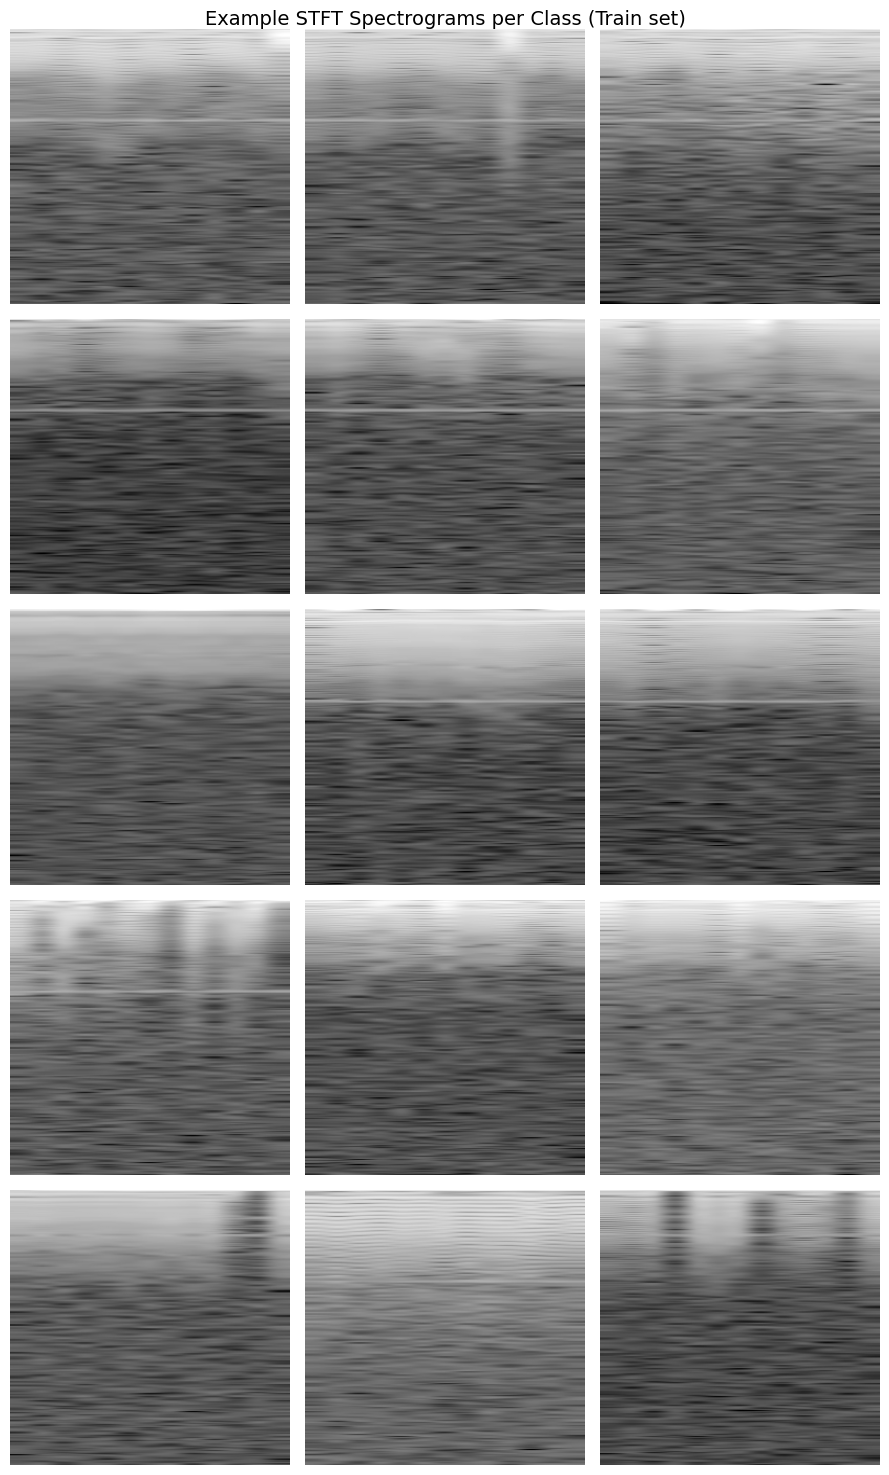

In [ ]:
# ============================================================
# ECG Arrhythmia Classification - Data Prep + Spectrogram Viz
# MIT-BIH: STFT (512 Hann) -> 256x256 spectrograms
# (No CNN / training here, only up to image generation)
# ============================================================

# -------------------------
# 0) Config & dependencies
# -------------------------
import os, random
import numpy as np
import wfdb
from wfdb import processing

import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal
from tensorflow.keras.utils import to_categorical

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Records per class (from the paper)
RECORDS = {
    "NOR": [100, 105, 215],
    "LBB": [109, 111, 214],
    "RBB": [118, 124, 212],
    "PVC": [106, 233],
    "APC": [207, 209, 232]
}

# Target split (paper): NOR/LBB/RBB/APC (450 train, 90 test), PVC (300 train, 60 test)
TARGET_TRAIN = {"NOR":450, "LBB":450, "RBB":450, "APC":450, "PVC":300}
TARGET_TEST  = {"NOR": 90, "LBB": 90, "RBB": 90, "APC": 90, "PVC": 60}

# Sampling
FS = 360           # Hz
WIN_SEC = 10       # seconds
WIN_SAMPLES = FS * WIN_SEC   # 3600 samples

# STFT / Spectrogram (paper choices)
STFT_NPERSEG  = 512   # window size
STFT_NOVERLAP = 256   # 50% overlap
SPEC_SIZE     = 256   # spectrogram image size (H x W)

# Class mapping
class_to_idx = {"NOR":0, "LBB":1, "RBB":2, "PVC":3, "APC":4}
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Config ready.")

# ------------------------------------------
# 1) Read signals & extract labeled segments
# ------------------------------------------
def read_signal(record_num, fs_target=FS):
    """Read one MIT-BIH record and resample to fs_target."""
    rec = wfdb.rdrecord(str(record_num), pn_dir="mitdb")
    names = [n.lower() for n in rec.sig_name]

    # Same lead selection rule as your main code
    if "v5" in names:
        ch = names.index("v5")
    elif "mlii" in names:
        ch = names.index("mlii")
    else:
        ch = 0

    sig = rec.p_signal[:, ch].astype(np.float32)
    fs = int(rec.fs)

    if fs != fs_target:
        sig = processing.resample_sig(sig, fs, fs_target)[0]
        fs = fs_target

    return sig, fs


def extract_segments(record_num, label, win_samples=WIN_SAMPLES):
    """
    Extract 10 s windows centered on annotated beats of a given label.

    Label mapping (MIT-BIH symbols):
      NOR: 'N'
      LBB: 'L'
      RBB: 'R'
      PVC: 'V'
      APC: 'A' or 'a'
    """
    sig, fs = read_signal(record_num)
    ann = wfdb.rdann(str(record_num), "atr", pn_dir="mitdb")

    out = []
    for idx, sym in zip(ann.sample, ann.symbol):
        if   label == "NOR" and sym == "N": center = idx
        elif label == "LBB" and sym == "L": center = idx
        elif label == "RBB" and sym == "R": center = idx
        elif label == "PVC" and sym == "V": center = idx
        elif label == "APC" and sym in ("A", "a"): center = idx
        else:
            continue

        # 10 s window centered on the beat
        start = max(center - win_samples // 2, 0)
        end   = start + win_samples
        if end <= len(sig):
            out.append(sig[start:end])

    return out


# Build pools per class (same as paper implementation)
pool = {cls: [] for cls in RECORDS}
for cls, recs in RECORDS.items():
    for r in recs:
        pool[cls].extend(extract_segments(r, cls))
    print(f"{cls}: segments extracted = {len(pool[cls])}")

# ---------------------------------------
# 2) Paper's fixed train/test split (1D)
# ---------------------------------------
rng = np.random.default_rng(SEED)

def take_n(lst, n):
    idx = rng.choice(len(lst), size=min(n, len(lst)), replace=False)
    return [lst[i] for i in idx]

train_X_1d, train_y = [], []
test_X_1d,  test_y  = [], []

for cls in ["NOR","LBB","RBB","APC","PVC"]:
    tr_n, te_n = TARGET_TRAIN[cls], TARGET_TEST[cls]
    cls_pool = pool[cls]

    train_segs = take_n(cls_pool, tr_n)
    chosen = set(id(x) for x in train_segs)
    remaining = [x for x in cls_pool if id(x) not in chosen]
    test_segs = take_n(remaining, te_n)

    train_X_1d += train_segs
    train_y    += [class_to_idx[cls]] * len(train_segs)
    test_X_1d  += test_segs
    test_y     += [class_to_idx[cls]] * len(test_segs)

# Arrays
train_X_1d = np.stack(train_X_1d)  # [N, 3600]
test_X_1d  = np.stack(test_X_1d)
train_y    = np.array(train_y, dtype=np.int64)
test_y     = np.array(test_y, dtype=np.int64)

print("Train 1D:", train_X_1d.shape, {k:int((train_y==v).sum()) for k,v in class_to_idx.items()})
print("Test  1D:", test_X_1d.shape,  {k:int((test_y==v).sum()) for k,v in class_to_idx.items()})

# ------------------------------------------
# 3) STFT -> 256x256 grayscale spectrograms
# ------------------------------------------
def stft_to_image(seg, fs=FS):
    """
    STFT with symmetric Hann (Hanning) window of 512 (paper),
    50% overlap, magnitude -> dB -> [0,255], resized to 256x256.
    """
    hann_sym = signal.windows.hann(STFT_NPERSEG, sym=True)
    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann_sym,
        nperseg=STFT_NPERSEG,
        noverlap=STFT_NOVERLAP,
        nfft=STFT_NPERSEG,
        boundary=None,
        padded=False
    )
    S = np.abs(Z) + 1e-12
    S_db = 20 * np.log10(S / S.max())
    S01 = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-12)
    img = Image.fromarray((S01 * 255).astype(np.uint8)).resize((SPEC_SIZE, SPEC_SIZE), Image.BICUBIC)
    return np.array(img, np.uint8)


def make_spec_set(X_1d, y):
    imgs = [stft_to_image(seg, FS) for seg in X_1d]
    X = np.expand_dims(np.array(imgs, np.float32) / 255.0, axis=-1)  # [N, H, W, 1]
    Y = to_categorical(y, num_classes=5)
    return X, Y

train_X_2d, train_y_oh = make_spec_set(train_X_1d, train_y)
test_X_2d,  test_y_oh  = make_spec_set(test_X_1d,  test_y)

print("Train 2D:", train_X_2d.shape)
print("Test  2D:", test_X_2d.shape)

# ------------------------------------------
# 4) Visualize spectrograms for each class
# ------------------------------------------
def show_sample_spectrograms_per_class(X_2d, y, idx_to_class, samples_per_class=3):
    """
    Show a few spectrograms per class from X_2d (shape [N, H, W, 1]).
    """
    num_classes = len(idx_to_class)
    plt.figure(figsize=(samples_per_class * 3, num_classes * 3))

    for cls_idx in range(num_classes):
        cls_name = idx_to_class[cls_idx]
        indices = np.where(y == cls_idx)[0]

        # If not enough samples, adjust count
        count = min(samples_per_class, len(indices))

        for j in range(count):
            i = indices[j]
            img = X_2d[i, :, :, 0]  # remove channel dimension

            plt.subplot(num_classes, samples_per_class, cls_idx * samples_per_class + j + 1)
            plt.imshow(img, cmap="gray", aspect="auto")
            plt.axis("off")
            if j == 0:
                plt.ylabel(cls_name, fontsize=10)

    plt.suptitle("Example STFT Spectrograms per Class (Train set)", fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the visualization
show_sample_spectrograms_per_class(train_X_2d, train_y, idx_to_class, samples_per_class=3)


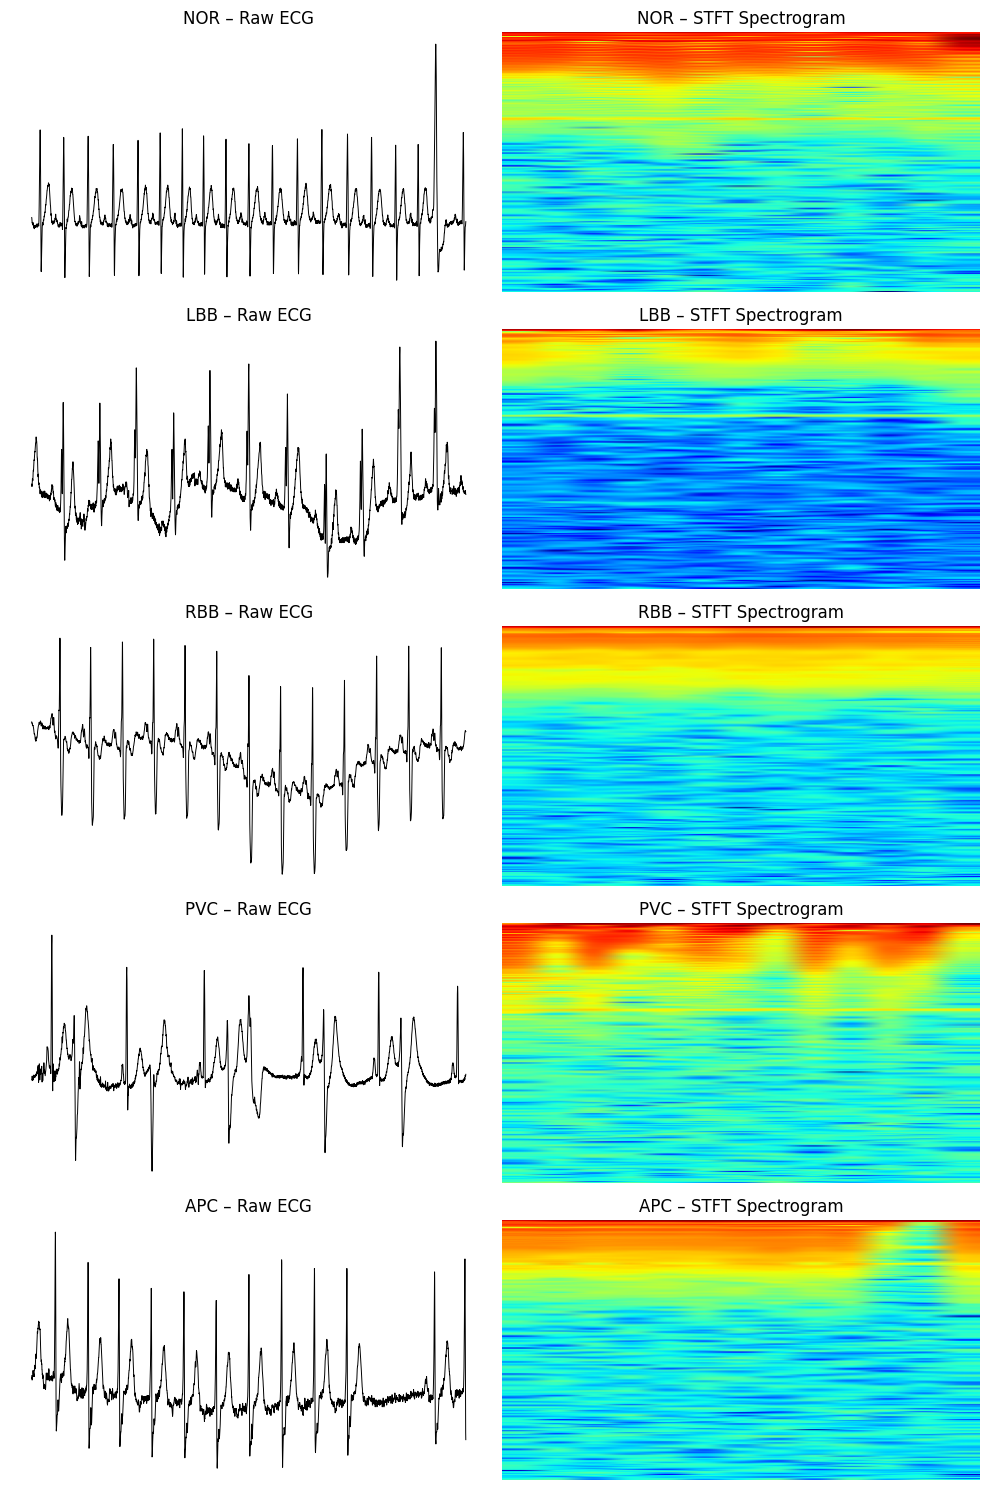

In [ ]:
# ============================================================
# Paper-style Visualization: ECG Beat + Colored Spectrogram
# ============================================================

import matplotlib.pyplot as plt
from scipy import signal
from PIL import Image

def stft_color(seg, fs=FS):
    """Return a COLOR spectrogram (jet colormap) for visualization only."""

    hann_sym = signal.windows.hann(STFT_NPERSEG, sym=True)
    f, t, Z = signal.stft(
        seg, fs=fs,
        window=hann_sym,
        nperseg=STFT_NPERSEG,
        noverlap=STFT_NOVERLAP,
        nfft=STFT_NPERSEG,
        boundary=None,
        padded=False
    )

    S = np.abs(Z) + 1e-12
    S_db = 20*np.log10(S / S.max())
    S01 = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-12)

    # Color using matplotlib colormap (jet)
    cmap = plt.get_cmap("jet")
    color_img = cmap(S01)[:, :, :3]  # remove alpha channel
    color_img = (color_img * 255).astype(np.uint8)

    # Resize to paper size
    color_img = Image.fromarray(color_img).resize((SPEC_SIZE, SPEC_SIZE))
    return np.array(color_img)


def show_signal_and_spectrogram(train_X_raw, train_X_2d, train_y, idx_to_class):
    """
    For each class: show (1) raw 10s ECG window, (2) color STFT spectrogram.
    """
    num_classes = len(idx_to_class)
    plt.figure(figsize=(10, num_classes * 3))

    for cls_idx in range(num_classes):
        cls_name = idx_to_class[cls_idx]

        # Pick first sample of each class
        idx = np.where(train_y == cls_idx)[0][0]

        raw_sig = train_X_raw[idx]
        spec_img = stft_color(raw_sig)

        # Raw signal plot
        plt.subplot(num_classes, 2, cls_idx*2 + 1)
        plt.plot(raw_sig, color="black", linewidth=0.7)
        plt.title(f"{cls_name} – Raw ECG")
        plt.axis("off")

        # Spectrogram
        plt.subplot(num_classes, 2, cls_idx*2 + 2)
        plt.imshow(spec_img, aspect="auto")
        plt.title(f"{cls_name} – STFT Spectrogram")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ---- CALL FUNCTION ----
show_signal_and_spectrogram(train_X_1d, train_X_2d, train_y, idx_to_class)
